In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/usr0/home/naveenr/projects/patient_provider')
sys.path.append('/Users/naveenr/Documents/patient_provider')

In [3]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import argparse
import secrets
import json
import matplotlib as mpl
from copy import deepcopy
import scipy.stats as stats 
import geopandas as gpd
from scipy.ndimage import gaussian_filter
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import Normalize

In [4]:
from patient.utils import get_results_matching_parameters, aggregate_normalize_data
from patient.utils import aggregate_data as aggregate_data_function
from patient.plotting import *

In [5]:
plt.style.use('ggplot')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('default')

In [6]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [7]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.rcParams['savefig.bbox'] = 'tight'

In [8]:
style_size = 'paper'

## New Plots

In [11]:
results = get_results_matching_parameters("baseline", "", {'num_patients': 1225})

# Method names
methods = ['random', 'greedy', 'lp', 'omniscient_optimal']
method_labels = {0: "Random", 1: "Greedy", 2: "Pairwise", 3: "Omniscient"}

# Calculate average utility per patient for each method
avg_utilities = []
std_utilities = []

for method in methods:
    key = f"{method}_patient_utilities"
    utilities = results[0][key]  # Get utilities for this method
    # Flatten: [seeds][trials][patients] -> all patient utilities
    all_patient_utils = []
    for seed in utilities:
        for trial in seed:
            all_patient_utils.extend(trial)
    
    # Calculate mean and std
    avg_utilities.append(np.mean(all_patient_utils))
    std_utilities.append(np.std(all_patient_utils) / np.sqrt(len(all_patient_utils)))  # Standard error

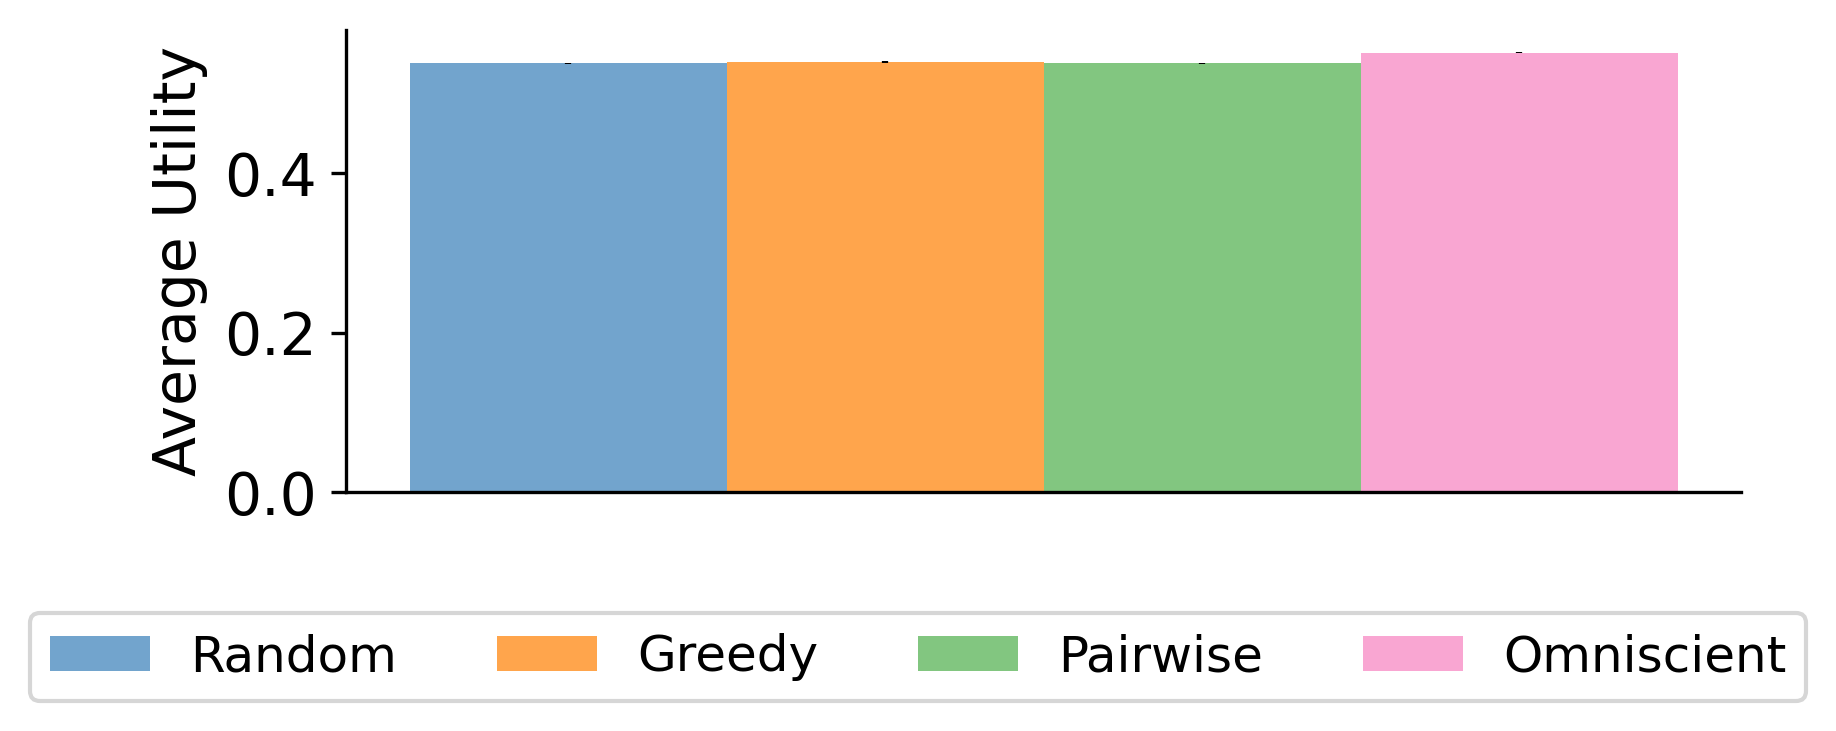

In [12]:
plot_dimensions = (1, 1)
x_labels = [[""]]  # Remove x-label since bar labels are self-explanatory
y_labels = [["Average Utility"]]
overall_format = {
    'figsize': (6, 2),  # Slightly wider for better spacing
    'style_size': 'paper',
    'hide_spines': True,
    'x_ticks': [[[[], []]]],
}

fig, ax = create_axes(plot_dimensions, overall_format, x_labels=x_labels, y_labels=y_labels)

# Bar plot with different colors
bar_format = {
    'style_size': 'paper',
    'color_palette': 'six_color',  # Different colors for each method
    'label_rotation': 0,
    'bar_width': 0.5  # Good balance between width and spacing,
}

x_groups = [0, 1, 2, 3]
plot_bar(ax[0][0], x_groups, avg_utilities, std_utilities, method_labels, bar_format)
legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'upper right', 'ncol': 5, 'bbox_to_anchor': (0.95,-0.05)}

create_legend(fig,ax,plot_dimensions,legend_format)
fig.savefig("../../results/figures/basics_comparison.pdf", dpi=300, bbox_inches='tight')


In [38]:
results = get_results_matching_parameters("baseline", "", {'num_patients': 1225})
params = results[0]['parameters']

# Load patient data to get zipcode mapping
patient_file = f"../../data/patient_data_{params['seed']}_{params['num_patients']}_{params['num_providers']}_comorbidity.json"
with open(patient_file, 'r') as f:
    patient_data = json.load(f)

# Get zipcodes for each patient
patient_zipcodes = [p['location'] for p in patient_data]

def calculate_zipcode_metrics(method, patient_zipcodes, num_providers):
    """Calculate match rate and average utility by zipcode for a method"""
    matches_by_zipcode = {}
    utility_by_zipcode = {}
    
    # Get data for this method
    utilities_key = f"{method}_patient_utilities"
    chosen_providers_key = f"{method}_chosen_providers"
    
    utilities = results[0][utilities_key]
    chosen_providers = results[0][chosen_providers_key]
    
    # For each seed, trial, patient
    for seed_idx in range(len(utilities)):
        for trial_idx in range(len(utilities[seed_idx])):
            for patient_idx in range(len(utilities[seed_idx][trial_idx])):
                utility = utilities[seed_idx][trial_idx][patient_idx]
                provider = chosen_providers[seed_idx][trial_idx][patient_idx]
                zipcode = patient_zipcodes[patient_idx]
                
                if zipcode not in matches_by_zipcode:
                    matches_by_zipcode[zipcode] = []
                    utility_by_zipcode[zipcode] = []
                
                # Patient matched if provider is in [0, num_providers-1]
                matched = (provider >= 0 and provider < num_providers)
                matches_by_zipcode[zipcode].append(1 if matched else 0)
                utility_by_zipcode[zipcode].append(utility)
    
    # Calculate averages
    match_rate = {z: np.mean(matches_by_zipcode[z]) for z in matches_by_zipcode}
    avg_utility = {z: np.mean(utility_by_zipcode[z]) for z in utility_by_zipcode}
    
    return match_rate, avg_utility
match_rate_omni, utility_omni = calculate_zipcode_metrics('omniscient_optimal', patient_zipcodes, params['num_providers'])

# Load CT zipcode shapefile
ct_zipcodes = gpd.read_file("../../data/ct.geojson")

# Add data to geodataframe
ct_zipcodes["match_rate"] = [match_rate_omni.get(z, -1) for z in ct_zipcodes["ZCTA5CE10"]]
ct_zipcodes["avg_utility"] = [utility_omni.get(z, -1) for z in ct_zipcodes["ZCTA5CE10"]]


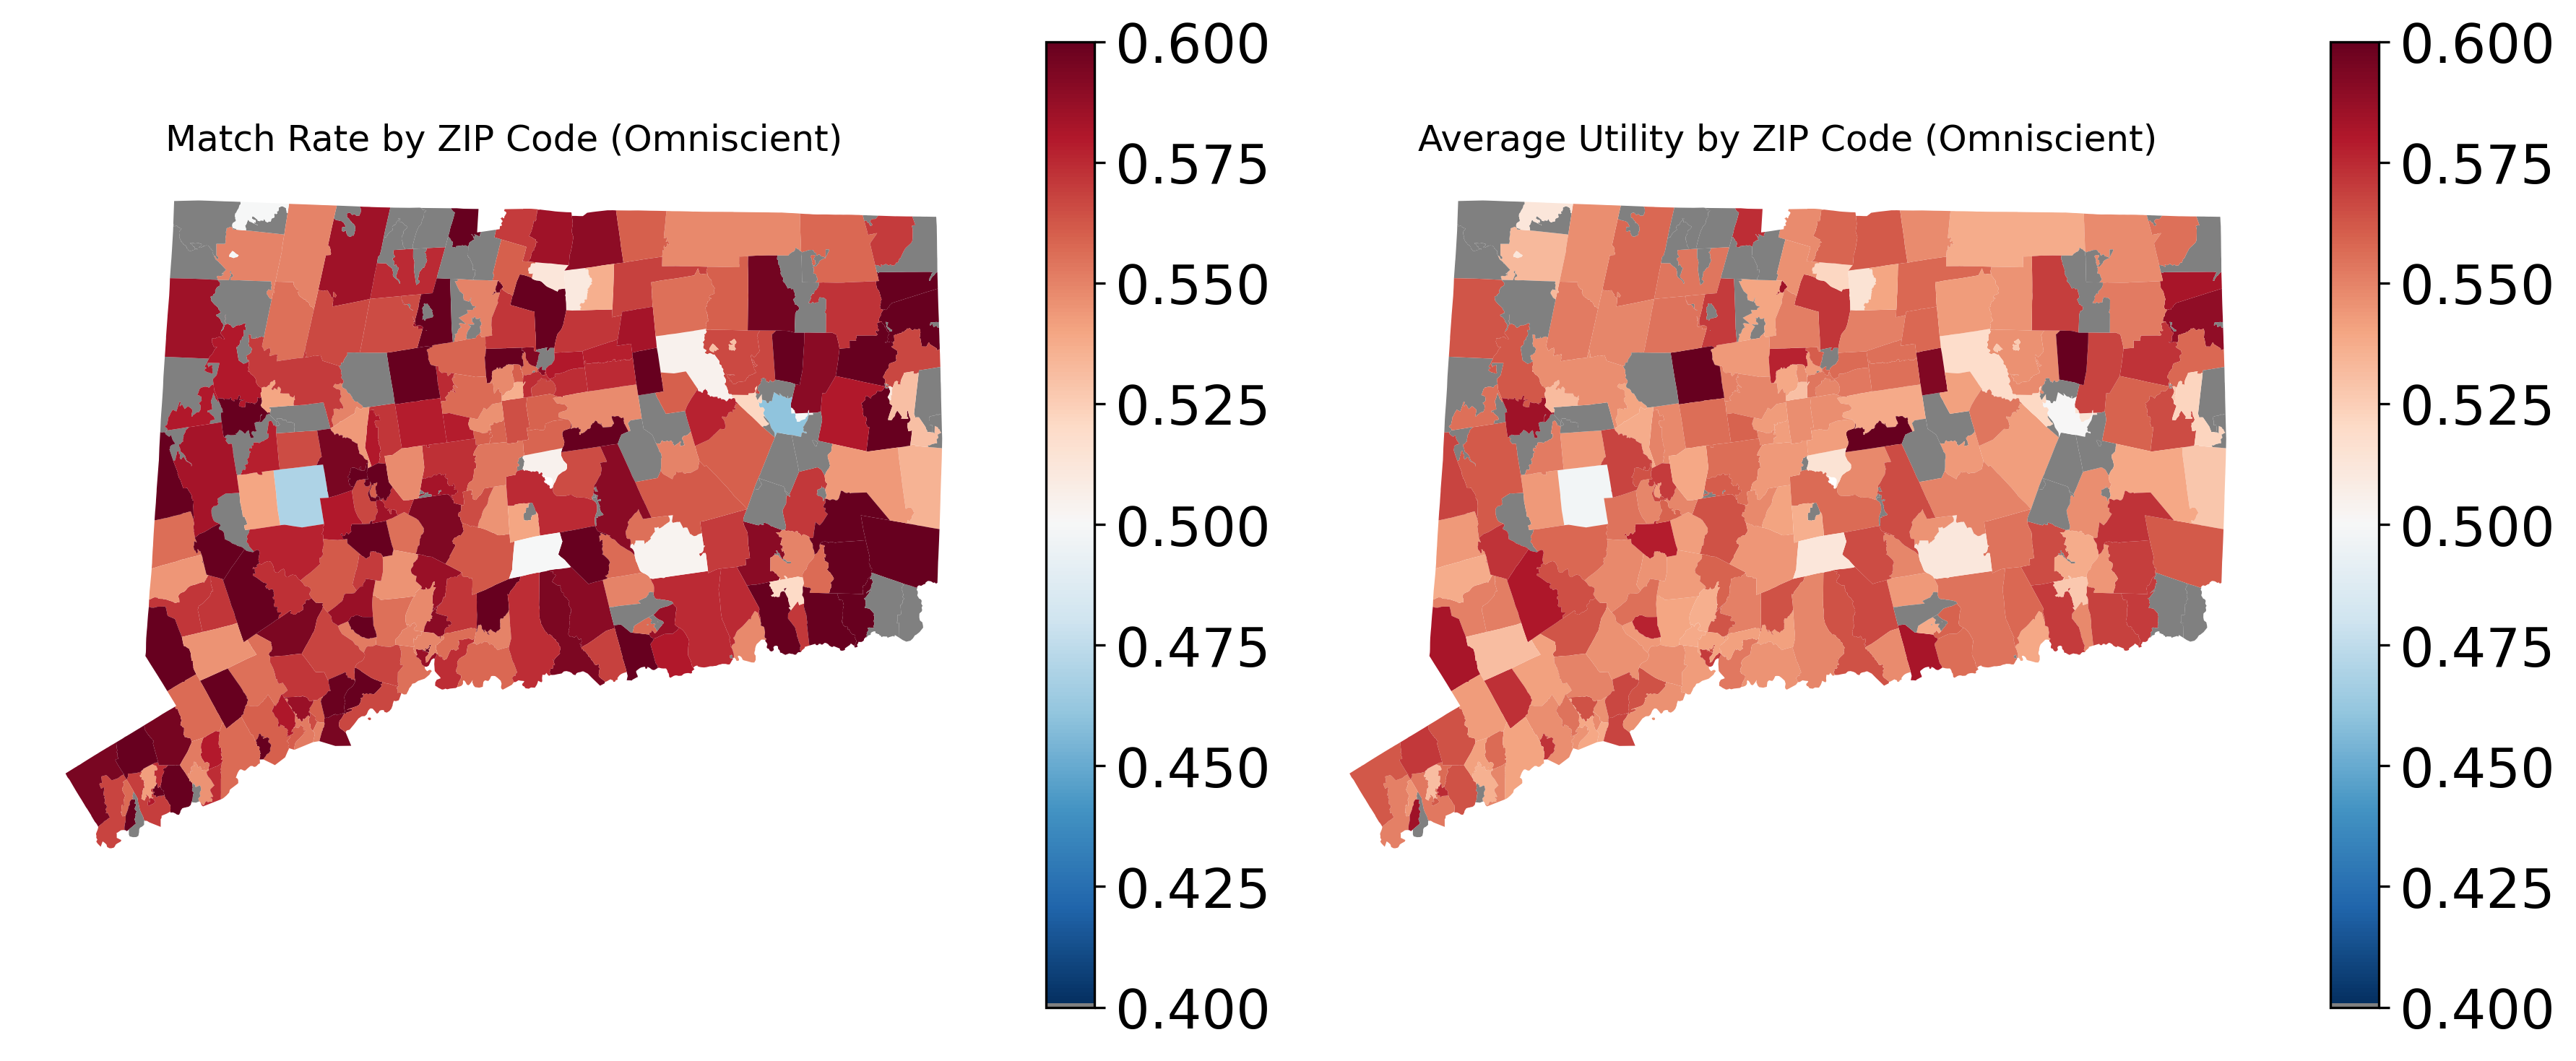

In [39]:
cmap_blue_red = mcolors.ListedColormap(["grey"] + plt.cm.RdBu_r(np.linspace(0, 1, 256)).tolist())

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Match Rate (0 to 1)
ct_zipcodes.plot(column="match_rate", ax=axes[0], legend=True, cmap=cmap_blue_red,
                 vmin=0.4, vmax=0.6, missing_kwds={"color": "lightgrey"})
axes[0].set_title("Match Rate by ZIP Code (Omniscient)")
axes[0].axis('off')

# Plot 2: Average Utility (0 to 1)
ct_zipcodes.plot(column="avg_utility", ax=axes[1], legend=True, cmap=cmap_blue_red,
                 vmin=0.4, vmax=0.6, missing_kwds={"color": "lightgrey"})
axes[1].set_title("Average Utility by ZIP Code (Omniscient)")
axes[1].axis('off')

plt.tight_layout()
fig.savefig("../../results/figures/geographic_analysis.pdf", dpi=300, bbox_inches='tight')
plt.show()


In [15]:
results = get_results_matching_parameters("baseline", "", {'num_patients': 1225})
methods = ['random', 'greedy', 'lp', 'omniscient_optimal']
method_labels = ["Random", "Greedy", "Pairwise", "Omniscient"]

# For colorblind-friendly palette (blue, orange, green, pink)
color_palette = ['#0072B2', '#E69F00', '#009E73', '#CC79A7']
markers = ['o', 's', '^', 'D']

# --------------------------------------
# Helper: compute metrics per method
# --------------------------------------
def compute_metrics(method):
    key_util = f"{method}_patient_utilities"
    key_match = f"{method}_chosen_providers"
    utilities = results[0][key_util]
    chosen_providers = results[0][key_match]
    num_providers = results[0]['parameters']['num_providers']

    match_rates = []
    avg_utils = []
    fairness_std = []
    fairness_minmax = []
    fairness_min = []

    for seed_idx in range(len(utilities)):
        for trial_idx in range(len(utilities[seed_idx])):
            util_arr = np.array(utilities[seed_idx][trial_idx])
            chosen_arr = np.array(chosen_providers[seed_idx][trial_idx])

            # Match indicator per patient
            matched = ((chosen_arr >= 0) & (chosen_arr < num_providers)).astype(int)

            # Per-patient "match quality" = utility if matched else 0
            match_quality = util_arr * matched

            # Store per-trial metrics
            match_rates.append(np.mean(matched))
            avg_utils.append(np.mean(match_quality))
            fairness_std.append(np.std(match_quality))
            fairness_minmax.append(np.max(match_quality) - np.min(match_quality))
            fairness_min.append(np.min(match_quality))

    # Average across all trials and seeds
    return {
        "match_rate": np.mean(match_rates),
        "avg_utility": np.mean(avg_utils),
        "fairness_std": np.mean(fairness_std),
        "fairness_minmax": np.mean(fairness_minmax),
        "fairness_min": np.mean(fairness_min),
    }

# Compute for all methods
metrics = {m: compute_metrics(m) for m in methods}


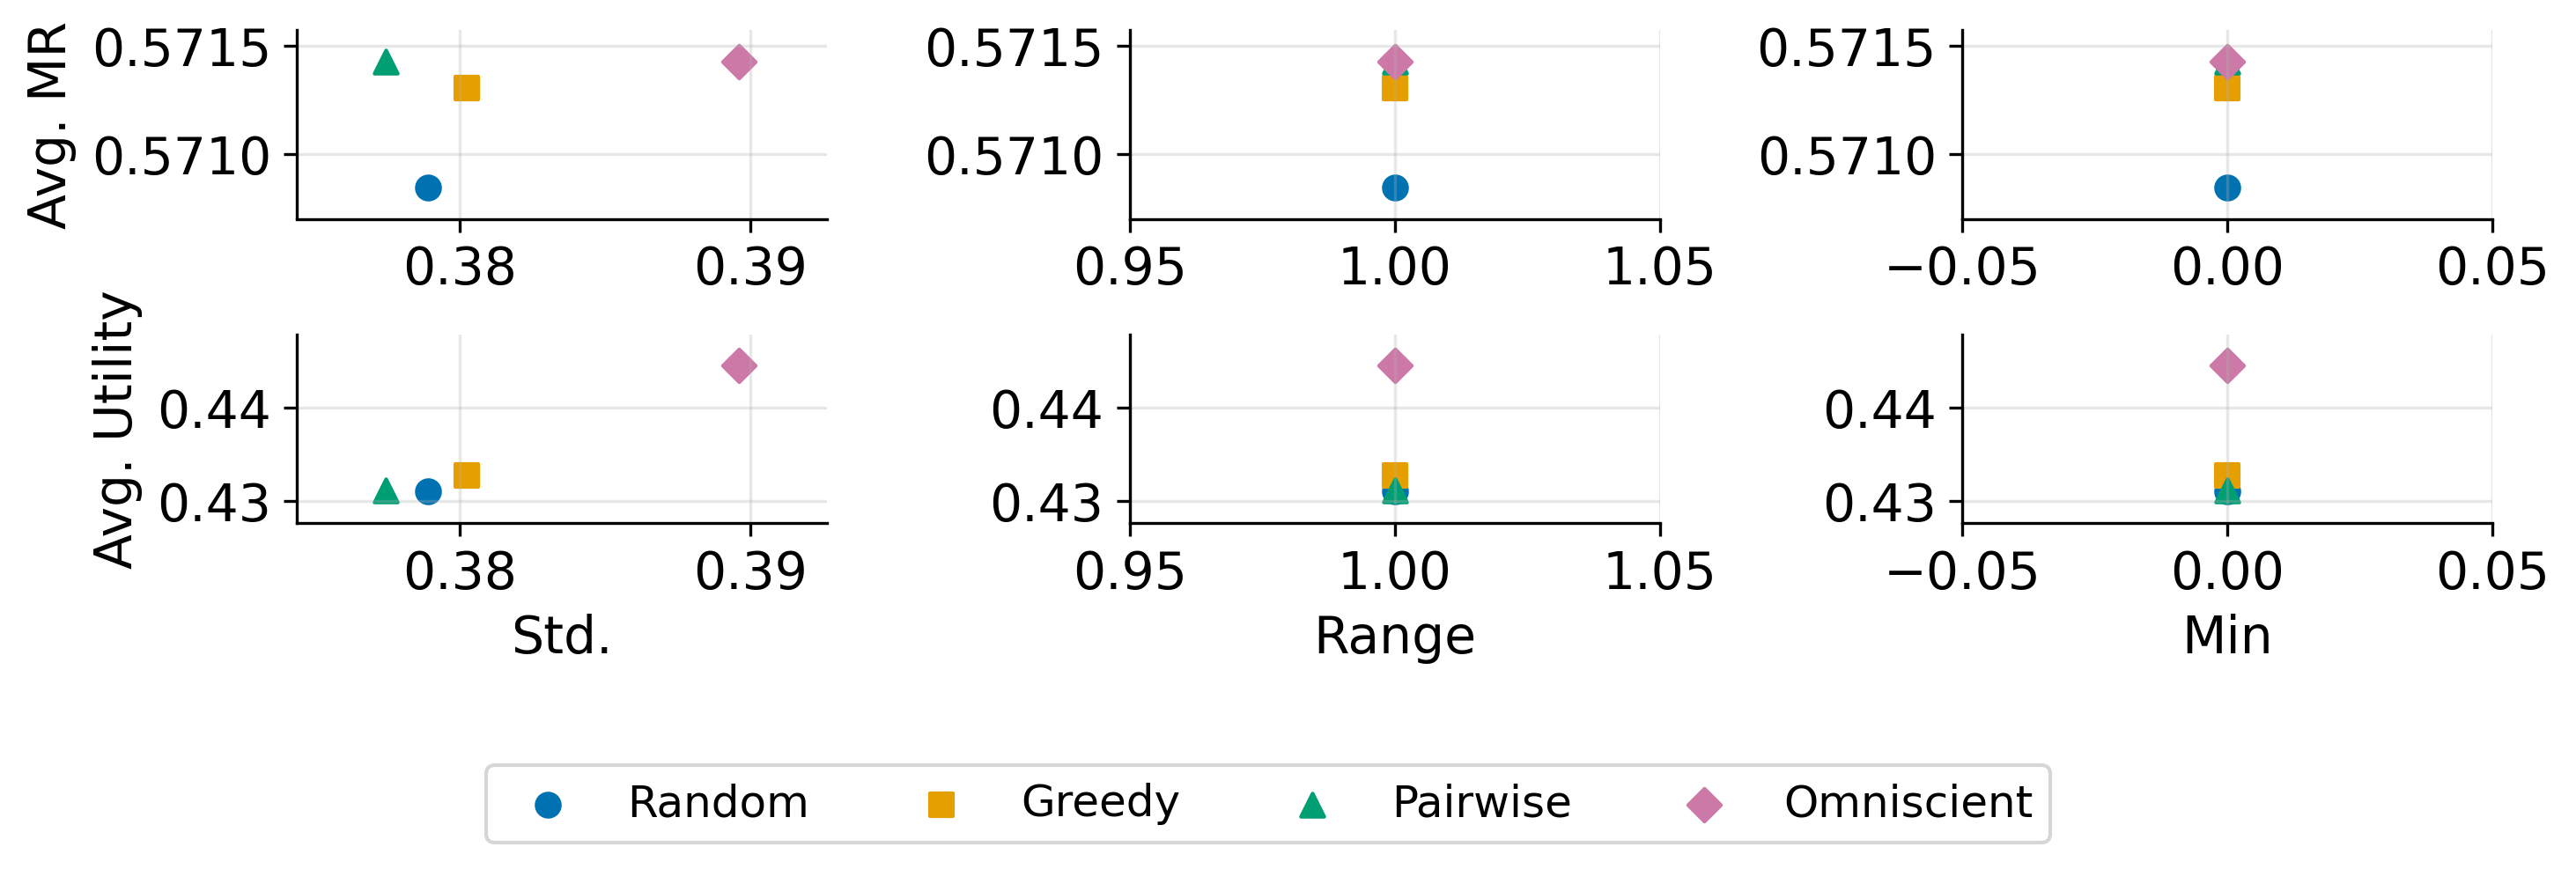

In [16]:
plot_dimensions = (2, 3)
x_labels = [
    ["", "", ""],
    ["Std.", "Range", "Min"],
]
y_labels = [
    ["Avg. MR", "", ""],
    ["Avg. Utility", "", ""],
]
sup_y_label = ""
fairness_metrics = ["fairness_std", "fairness_minmax", "fairness_min"]
y_metrics = ["match_rate", "avg_utility"]

# Helper to compute padded limits
def padded_limits(values, pad_frac=0.25, min_pad=0.05):
    vmin, vmax = np.min(values), np.max(values)
    if vmax == vmin:
        margin = min_pad
    else:
        margin = pad_frac * (vmax - vmin)
    return [vmin - margin, vmax + margin]

# Compute base per-metric limits
x_limits_dict = {m: padded_limits([metrics[k][m] for k in methods]) for m in fairness_metrics}
y_limits_dict = {m: padded_limits([metrics[k][m] for k in methods]) for m in y_metrics}

# Build 2×3×2 list structure
x_lims = [[[x_limits_dict[m] for m in fairness_metrics] for _ in range(2)]]
y_lims = [[[y_limits_dict[m]] * 3 for m in y_metrics]]

# Expand properly to match your function’s (2,3,2) indexing
x_lims = [[ [x_limits_dict[metric] for metric in fairness_metrics] for _ in range(2) ]]
x_lims = x_lims[0]  # (2x3x2) nested list form
y_lims = [ [y_limits_dict[y_metric] for _ in fairness_metrics] for y_metric in y_metrics ]




overall_format = {
    'figsize': (10, 3),
    'style_size': 'paper',
    'hide_spines': True,
    'x_lim': x_lims,
    'y_lim': y_lims,
    'has_grid': True,
}

fig, ax = create_axes(plot_dimensions, overall_format, x_labels=x_labels, y_labels=y_labels, sup_y_label=sup_y_label)

# --------------------------------------
# Scatter plots
# --------------------------------------
fairness_metrics = ["fairness_std", "fairness_minmax", "fairness_min"]

for i_row, y_metric in enumerate(["match_rate", "avg_utility"]):
    for i_col, x_metric in enumerate(fairness_metrics):
        for i_method, method in enumerate(methods):
            ax[i_row][i_col].scatter(
                metrics[method][x_metric],
                metrics[method][y_metric],
                color=color_palette[i_method],
                marker=markers[i_method],
                s=40,
                label=method_labels[i_method]
            )

        ax[i_row][i_col].grid(True, alpha=0.3)

# --------------------------------------
# Legend (global)
# --------------------------------------
legend_format = {
    'style_size': 'paper',
    'type': 'is_global',
    'loc': 'upper center',
    'ncol': 4,
    'bbox_to_anchor': (0.5, 0)
}
create_legend(fig, ax, plot_dimensions, legend_format)

# --------------------------------------
# Save + show
# --------------------------------------
plt.tight_layout()
fig.savefig("../../results/figures/fairness_plot.pdf", dpi=300, bbox_inches='tight')
plt.show()


In [18]:
results = get_results_matching_parameters("baseline", "", {'num_patients': 1225})
assortments = results[0]["omniscient_optimal_assortments"]

# Flatten across all seeds and trials
all_patient_counts = []
all_provider_counts = []

for seed in assortments:
    A = np.array(seed)  # shape: num_patients x num_providers
    patient_counts = A.sum(axis=1)  # how many providers each patient sees
    provider_counts = A.sum(axis=0)  # how many patients each provider sees
    all_patient_counts.extend(patient_counts)
    all_provider_counts.extend(provider_counts)

all_patient_counts = np.array(all_patient_counts)
all_provider_counts = np.array(all_provider_counts)

/tmp/ipykernel_2536662/1794922065.py:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(all_provider_counts, ax=ax[0][1], fill=True, color="#55A868", label="Providers")


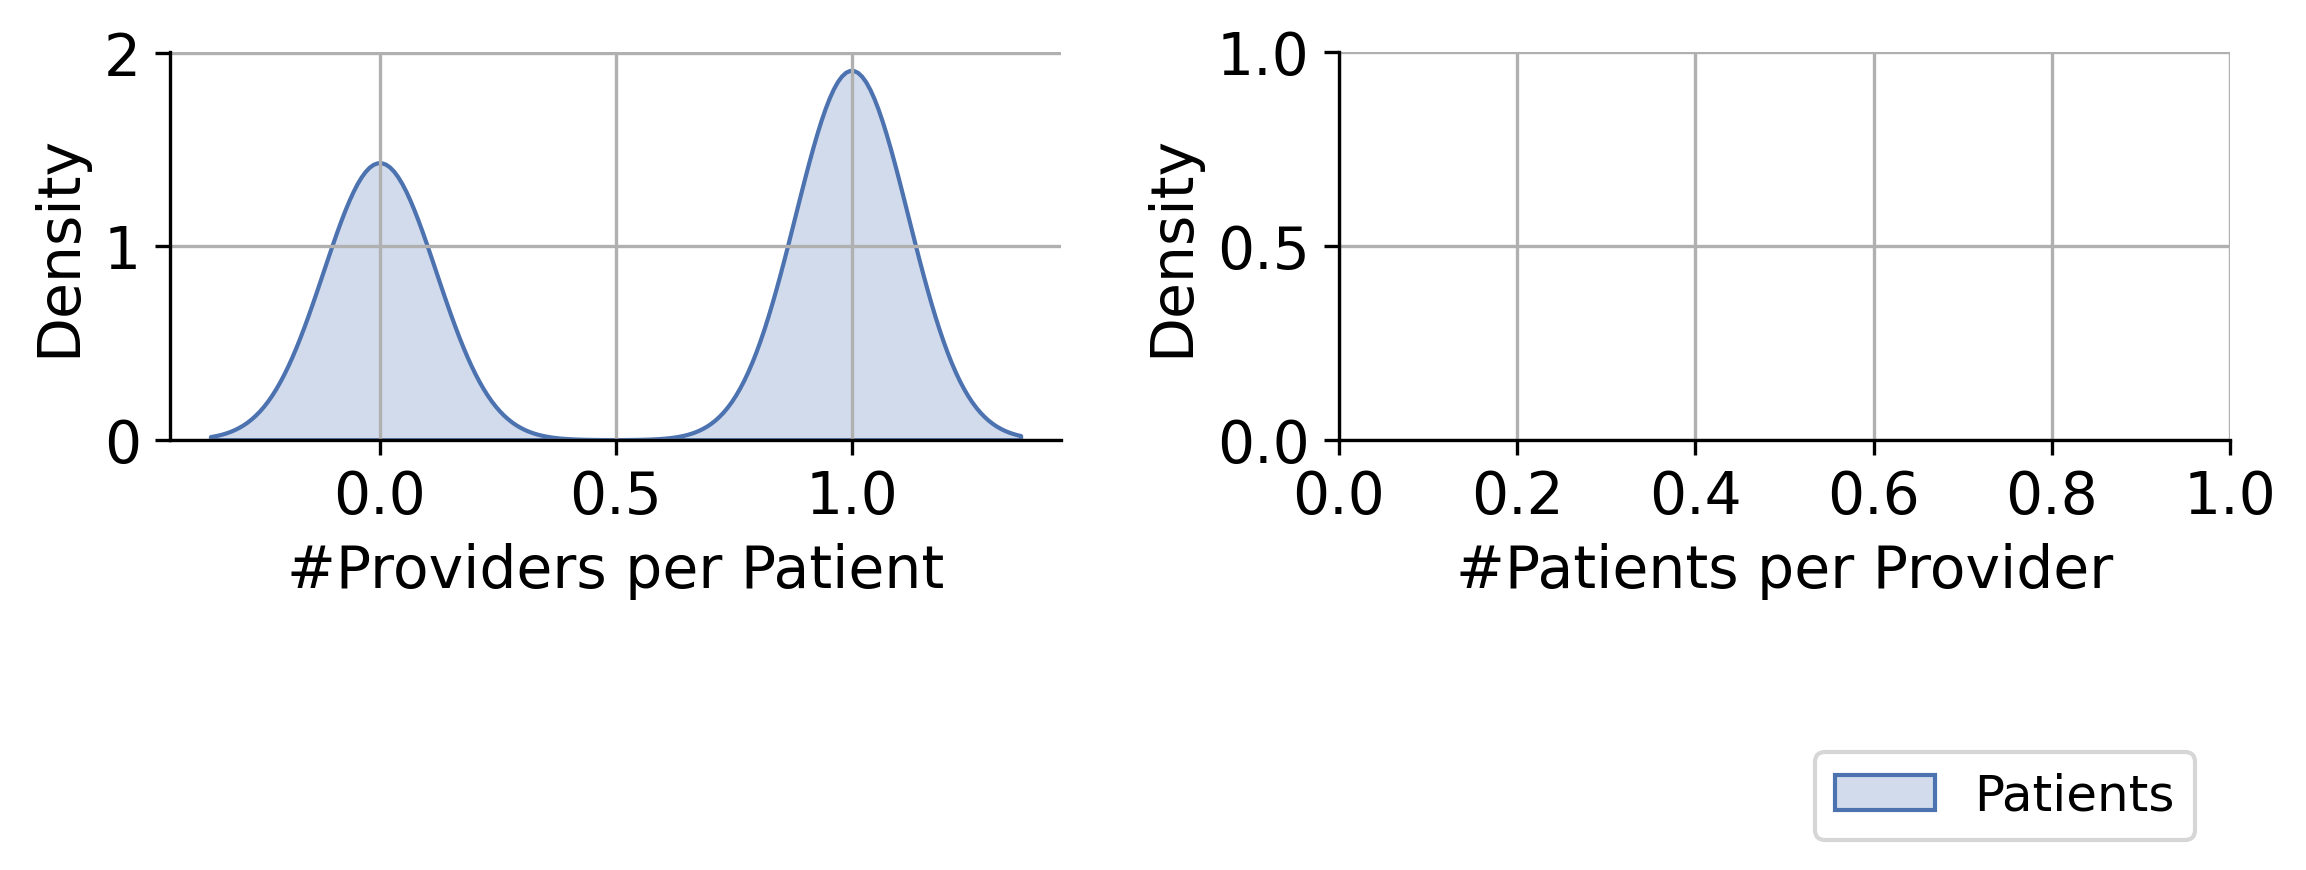

In [19]:
plot_dimensions = (1, 2)
x_labels = [["#Providers per Patient", "#Patients per Provider"]]
y_labels = [["Density", ""]]
sup_y_label = ""

overall_format = {
    'figsize': (8, 2.5),
    'style_size': 'paper',
    'hide_spines': True,
    'has_grid': True,
}

fig, ax = create_axes(plot_dimensions, overall_format, x_labels=x_labels, y_labels=y_labels, sup_y_label=sup_y_label)

# --------------------------------------
# Plot KDEs (or histograms if discrete)
# --------------------------------------
sns.kdeplot(all_patient_counts, ax=ax[0][0], fill=True, color="#4C72B0", label="Patients")
sns.kdeplot(all_provider_counts, ax=ax[0][1], fill=True, color="#55A868", label="Providers")

# Optionally, if your data is integer and not large, histograms may be clearer:
# ax[0][0].hist(all_patient_counts, bins=np.arange(0, max(all_patient_counts)+1)-0.5, color="#4C72B0", alpha=0.7)
# ax[0][1].hist(all_provider_counts, bins=np.arange(0, max(all_provider_counts)+1)-0.5, color="#55A868", alpha=0.7)

# --------------------------------------
# Legend and save
# --------------------------------------
legend_format = {
    'style_size': 'paper',
    'type': 'is_global',
    'loc': 'upper right',
    'ncol': 2,
    'bbox_to_anchor': (0.95, -0.05),
}
create_legend(fig, ax, plot_dimensions, legend_format)

plt.tight_layout()
fig.savefig("../../results/figures/assortment_marginals.pdf", dpi=300, bbox_inches="tight")
plt.show()


In [20]:
def avg_utility_by_position(results, method_key):
    """
    results: list of dicts from get_results_matching_parameters
    method_key: e.g., 'omniscient_optimal_patient_utilities'
    
    Returns:
        avg_util: np.array, average utility by position
        std_util: np.array, standard deviation by position
    """
    all_trials = []
    
    for r in results:
        seeds = r[method_key]  # list of seeds
        for seed in seeds:
            for trial in seed:  # trial is a list of patient utilities
                all_trials.append(trial)
    
    # Pad trials to max length (if trials differ in patient count)
    max_len = max(len(trial) for trial in all_trials)
    padded_trials = np.array([np.pad(trial, (0, max_len - len(trial)), constant_values=np.nan)
                              for trial in all_trials])
    
    avg_util = np.nanmean(padded_trials, axis=0)
    std_util = np.nanstd(padded_trials, axis=0)
    
    return avg_util, std_util
results = get_results_matching_parameters("baseline", "", {'num_patients': 1225})

# --- Example usage ---
avg_util, std_util = avg_utility_by_position(results, "omniscient_optimal_patient_utilities")



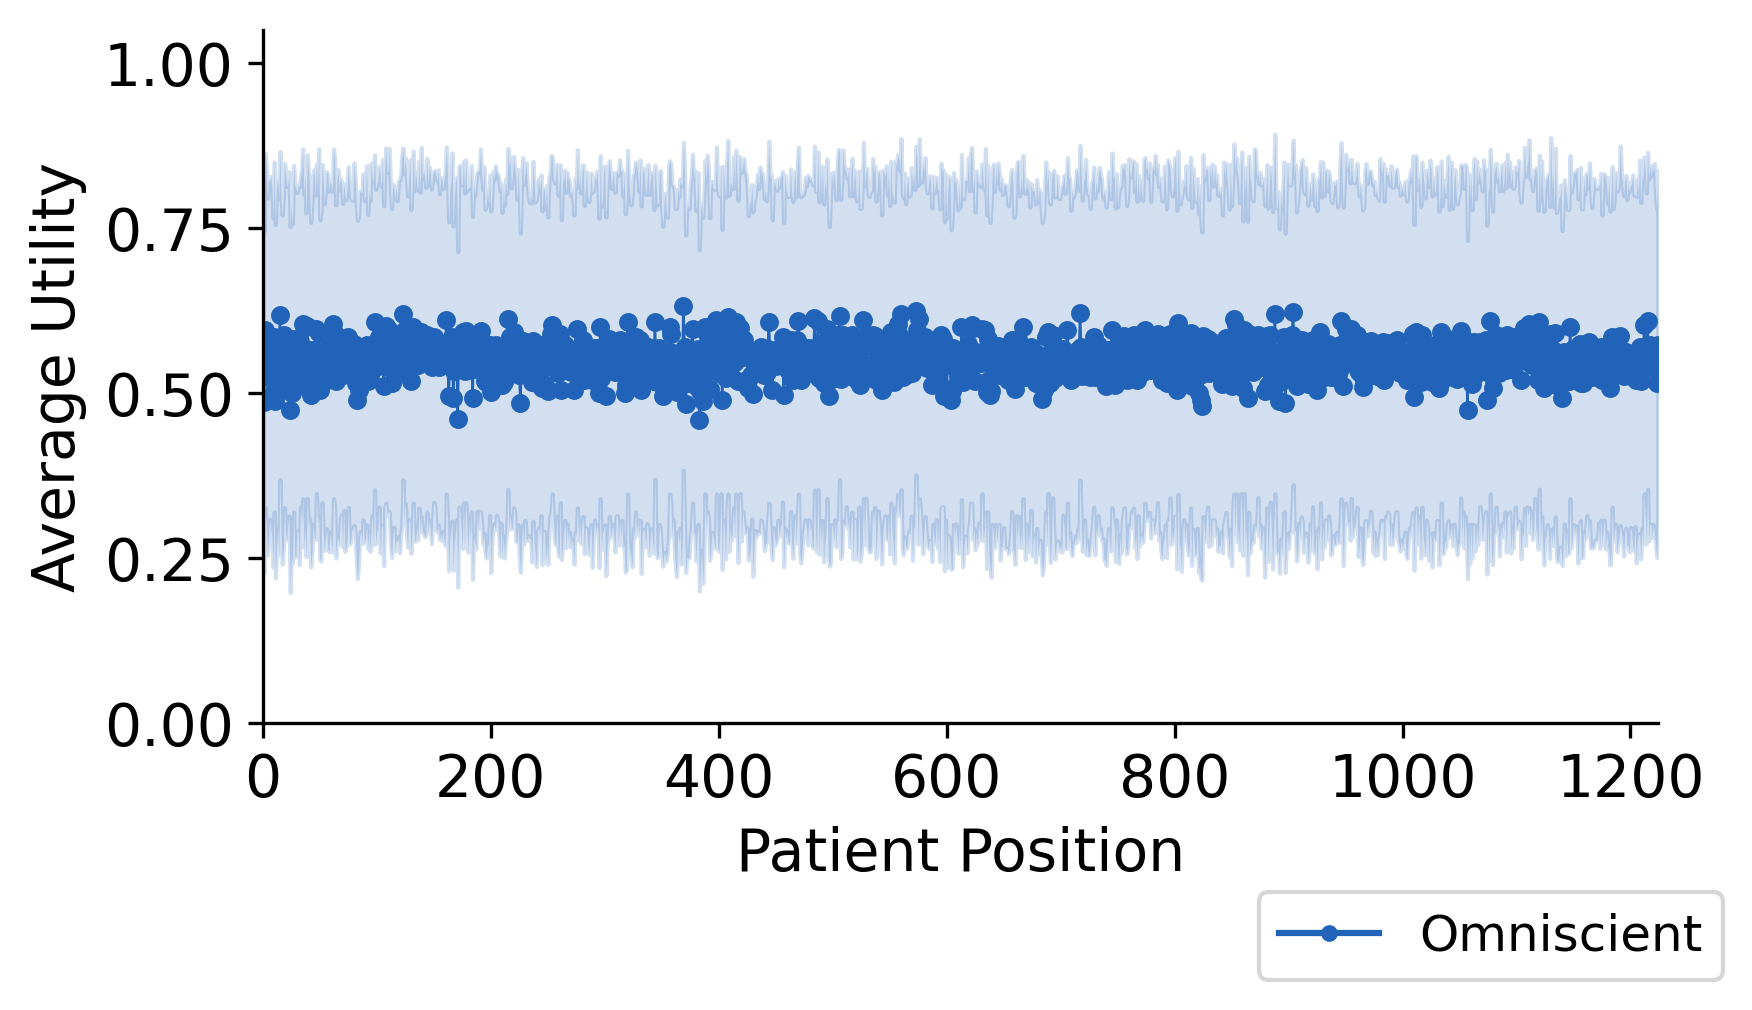

In [21]:
x_values = np.arange(len(avg_util))

# --- Plot ---
plot_dimensions = (1, 1)
x_labels = [["Patient Position"]]
y_labels = [["Average Utility"]]
overall_format = {
    'figsize': (6, 3),
    'style_size': 'paper',
    'hide_spines': True,
    'y_lim': [[[0, 1.05]]],
    'x_lim': [[[0, len(avg_util) - 1]]],
}

fig, ax = create_axes(plot_dimensions, overall_format, x_labels=x_labels, y_labels=y_labels)

# Line + scatter
line_format = {'color_palette': '#2163B8', 'size': 50}  # blue color
plot_line(ax[0][0], [x_values], [avg_util], [std_util], ["Omniscient"], line_format)
plot_scatter(ax[0][0], [x_values], [avg_util], [], line_format)

# Legend
legend_format = {
    'style_size': 'paper',
    'type': 'is_global',
    'loc': 'upper right',
    'ncol': 1,
    'bbox_to_anchor': (0.95, -0.05),
    'show_point': True,
    'fontsize': 12
}
create_legend(fig, ax, plot_dimensions, legend_format)

# Save
fig.savefig("../../results/figures/avg_utility_by_patient_position_omniscient.pdf",
            dpi=300, bbox_inches='tight')


In [22]:
with open("../../data/ct_zipcode_cluster.json", 'r') as f:
    zipcode_to_cluster = json.load(f)

# Get unique clusters to assign random values for missing zipcodes
available_clusters = list(set(zipcode_to_cluster.values()))

def get_cluster_for_zipcode(zipcode, zipcode_to_cluster, available_clusters):
    """Get cluster for zipcode, or random cluster if not in mapping"""
    if zipcode in zipcode_to_cluster:
        return zipcode_to_cluster[zipcode]
    else:
        # Assign random cluster based on available values
        return np.random.choice(available_clusters)

def calculate_fairness_metrics(results, patient_zipcodes, zipcode_to_cluster, available_clusters, method='lp'):
    """Calculate average utility, geographic spread, and overall spread"""
    utilities_key = f"{method}_patient_utilities"
    utilities = results[0][utilities_key]
    
    # Flatten utilities: [seeds][trials][patients]
    all_utilities = []
    for seed_idx in range(len(utilities)):
        for trial_idx in range(len(utilities[seed_idx])):
            all_utilities.append(utilities[seed_idx][trial_idx])
    
    # Calculate average utility across all patients and trials
    avg_utility = np.mean([np.mean(trial) for trial in all_utilities])
    
    # Calculate overall spread (std dev across all patients)
    overall_spread = np.mean([np.std(trial) for trial in all_utilities])
    
    # Calculate geographic spread (std dev of average utility by cluster)
    cluster_utilities = {}
    for trial in all_utilities:
        for patient_idx, utility in enumerate(trial):
            zipcode = patient_zipcodes[patient_idx]
            cluster = get_cluster_for_zipcode(zipcode, zipcode_to_cluster, available_clusters)
            
            if cluster not in cluster_utilities:
                cluster_utilities[cluster] = []
            cluster_utilities[cluster].append(utility)
    
    # Average utility per cluster
    cluster_avg_utilities = [np.mean(cluster_utilities[c]) for c in cluster_utilities]
    geographic_spread = np.std(cluster_avg_utilities)
    
    return avg_utility, geographic_spread, overall_spread

# Get fairness constraint values
fairness_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

# Store results for each fairness level
avg_utilities = []
geographic_spreads = []
overall_spreads = []

for fairness_val in fairness_values:
    # Get results for this fairness constraint
    results = get_results_matching_parameters("fairness", "", {'fairness_constraint': fairness_val, 'num_patients': 1225})
    params = results[0]['parameters']
    
    # Load patient data
    patient_file = f"../../data/patient_data_{params['seed']}_{params['num_patients']}_{params['num_providers']}_comorbidity.json"
    with open(patient_file, 'r') as f:
        patient_data = json.load(f)
    patient_zipcodes = [p['location'] for p in patient_data]
    
    # Calculate metrics (using 'lp' method, change if needed)
    avg_util, geo_spread, overall_spread = calculate_fairness_metrics(
        results, patient_zipcodes, zipcode_to_cluster, available_clusters, method='omniscient_optimal'
    )
    
    avg_utilities.append(avg_util)
    geographic_spreads.append(geo_spread)
    overall_spreads.append(overall_spread)


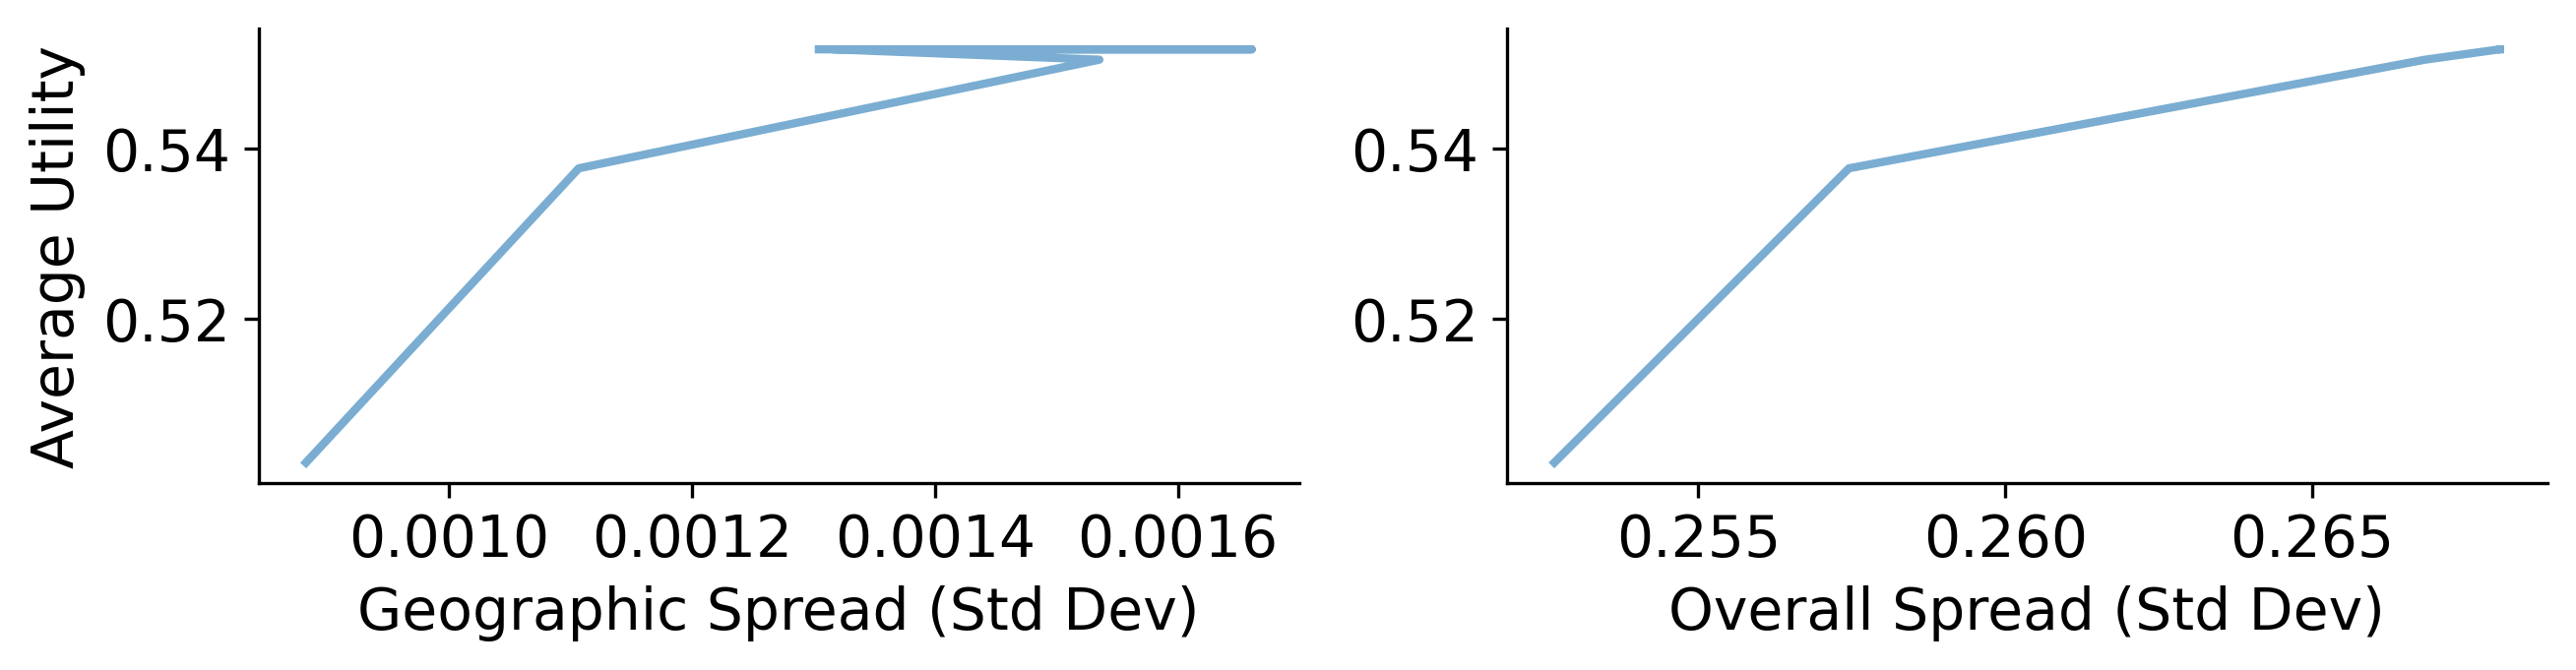

In [23]:
plot_dimensions = (1, 2)
x_labels = [["Geographic Spread (Std Dev)", "Overall Spread (Std Dev)"]]
y_labels = [["Average Utility", ""]]

overall_format = {
    'figsize': (10, 2),
    'style_size': 'paper',
    'hide_spines': True,
}

fig, ax = create_axes(plot_dimensions, overall_format, x_labels=x_labels, y_labels=y_labels)

# Plot 1: Utility vs Geographic Spread
line_format = {
    'color_palette': 'two_color_blue_red',
    'linewidth': 2,
    'no_marker': False
}
plot_line(ax[0][0], [geographic_spreads], [avg_utilities], [[0]*len(avg_utilities)], ['Pairwise'], line_format)

# Plot 2: Utility vs Overall Spread
plot_line(ax[0][1], [overall_spreads], [avg_utilities], [[0]*len(avg_utilities)], ['Pairwise'], line_format)

fig.savefig("../../results/figures/fairness_pareto_curves.pdf", dpi=300, bbox_inches='tight')
plt.show()


In [28]:
def avg_utility_by_position(results, method_key):
    """
    results: list of dicts from get_results_matching_parameters
    method_key: e.g., 'omniscient_optimal_patient_utilities'
    
    Returns:
        avg_util: np.array, average utility by position
        std_util: np.array, standard deviation by position
    """
    all_trials = []
    
    for r in results:
        seeds = r[method_key]  # list of seeds
        for seed in seeds:
            for trial in seed:  # trial is a list of patient utilities
                all_trials.append(trial)
    
    # Pad trials to max length (if trials differ in patient count)
    max_len = max(len(trial) for trial in all_trials)
    padded_trials = np.array([np.pad(trial, (0, max_len - len(trial)), constant_values=np.nan)
                              for trial in all_trials])
    
    avg_util = np.nanmean(padded_trials, axis=0)
    std_util = np.nanstd(padded_trials, axis=0)
    
    return avg_util, std_util
results = get_results_matching_parameters("dynamic", "", {'num_patients': 1225,'online_arrival': True})
# --- Example usage ---
avg_util, std_util = avg_utility_by_position(results, "omniscient_optimal_patient_utilities")



0


ValueError: max() arg is an empty sequence

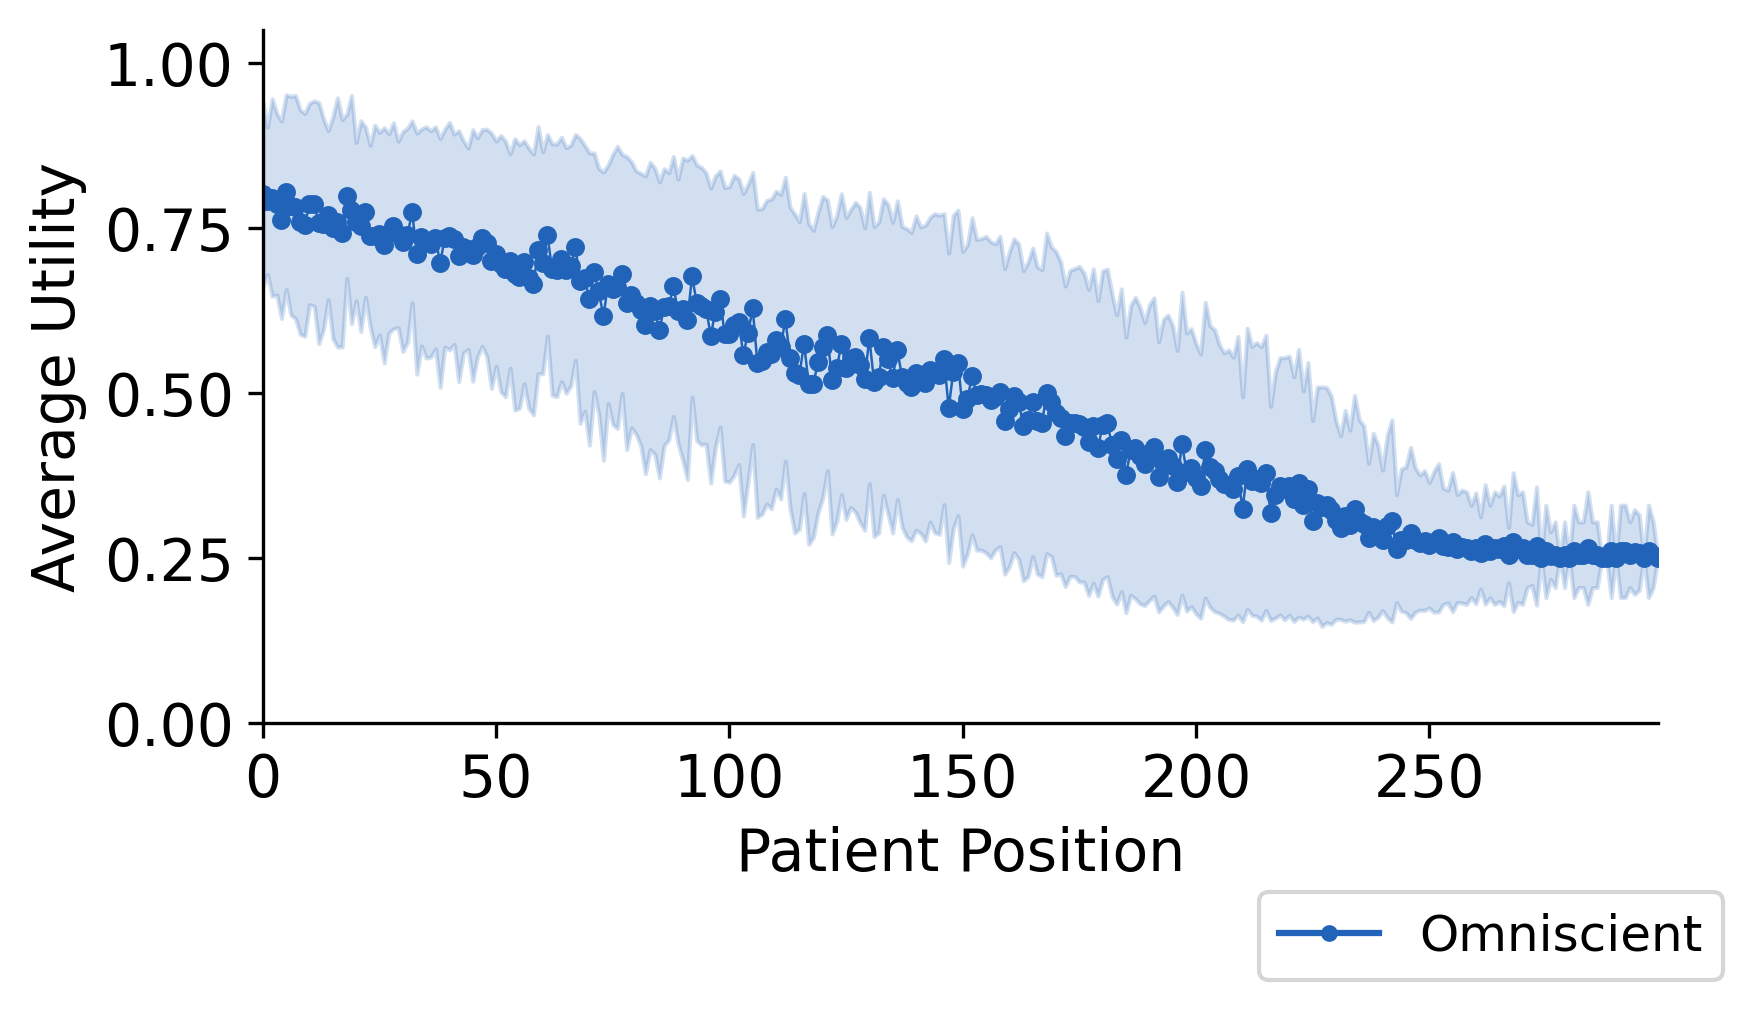

In [27]:
x_values = np.arange(len(avg_util))

# --- Plot ---
plot_dimensions = (1, 1)
x_labels = [["Patient Position"]]
y_labels = [["Average Utility"]]
overall_format = {
    'figsize': (6, 3),
    'style_size': 'paper',
    'hide_spines': True,
    'y_lim': [[[0, 1.05]]],
    'x_lim': [[[0, len(avg_util) - 1]]],
}

fig, ax = create_axes(plot_dimensions, overall_format, x_labels=x_labels, y_labels=y_labels)

# Line + scatter
line_format = {'color_palette': '#2163B8', 'size': 50}  # blue color
plot_line(ax[0][0], [x_values], [avg_util], [std_util], ["Omniscient"], line_format)
plot_scatter(ax[0][0], [x_values], [avg_util], [], line_format)

# Legend
legend_format = {
    'style_size': 'paper',
    'type': 'is_global',
    'loc': 'upper right',
    'ncol': 1,
    'bbox_to_anchor': (0.95, -0.05),
    'show_point': True,
    'fontsize': 12
}
create_legend(fig, ax, plot_dimensions, legend_format)

# Save
fig.savefig("../../results/figures/avg_utility_position_online.pdf",
            dpi=300, bbox_inches='tight')


In [29]:
# Get results from the new provider experiment
results = get_results_matching_parameters("dynamic", "", {'num_patients': 1225,'new_provider': True})  # Adjust folder/params as needed
params = results[0]['parameters']

methods = ['random', 'greedy', 'lp', 'omniscient_optimal']
method_labels = ['Random', 'Greedy', 'Pairwise', 'Omniscient']

# Collect utility distributions for switchers
before_utilities = {method: [] for method in methods}
after_utilities = {method: [] for method in methods}

for method in methods:
    utilities_key = f"{method}_patient_utilities"
    utilities = results[0][utilities_key]  # Shape: (seeds, trials, patients, 2)
    
    # For each seed, trial, patient
    for seed_idx in range(len(utilities)):
        for trial_idx in range(len(utilities[seed_idx])):
            for patient_idx in range(len(utilities[seed_idx][trial_idx])):
                before = utilities[seed_idx][trial_idx][patient_idx][0]
                after = utilities[seed_idx][trial_idx][patient_idx][1]
                
                # Check if patient switched (utility changed)
                if abs(after - before) > 1e-6:  # Small epsilon for floating point comparison
                    before_utilities[method].append(before)
                    after_utilities[method].append(after)



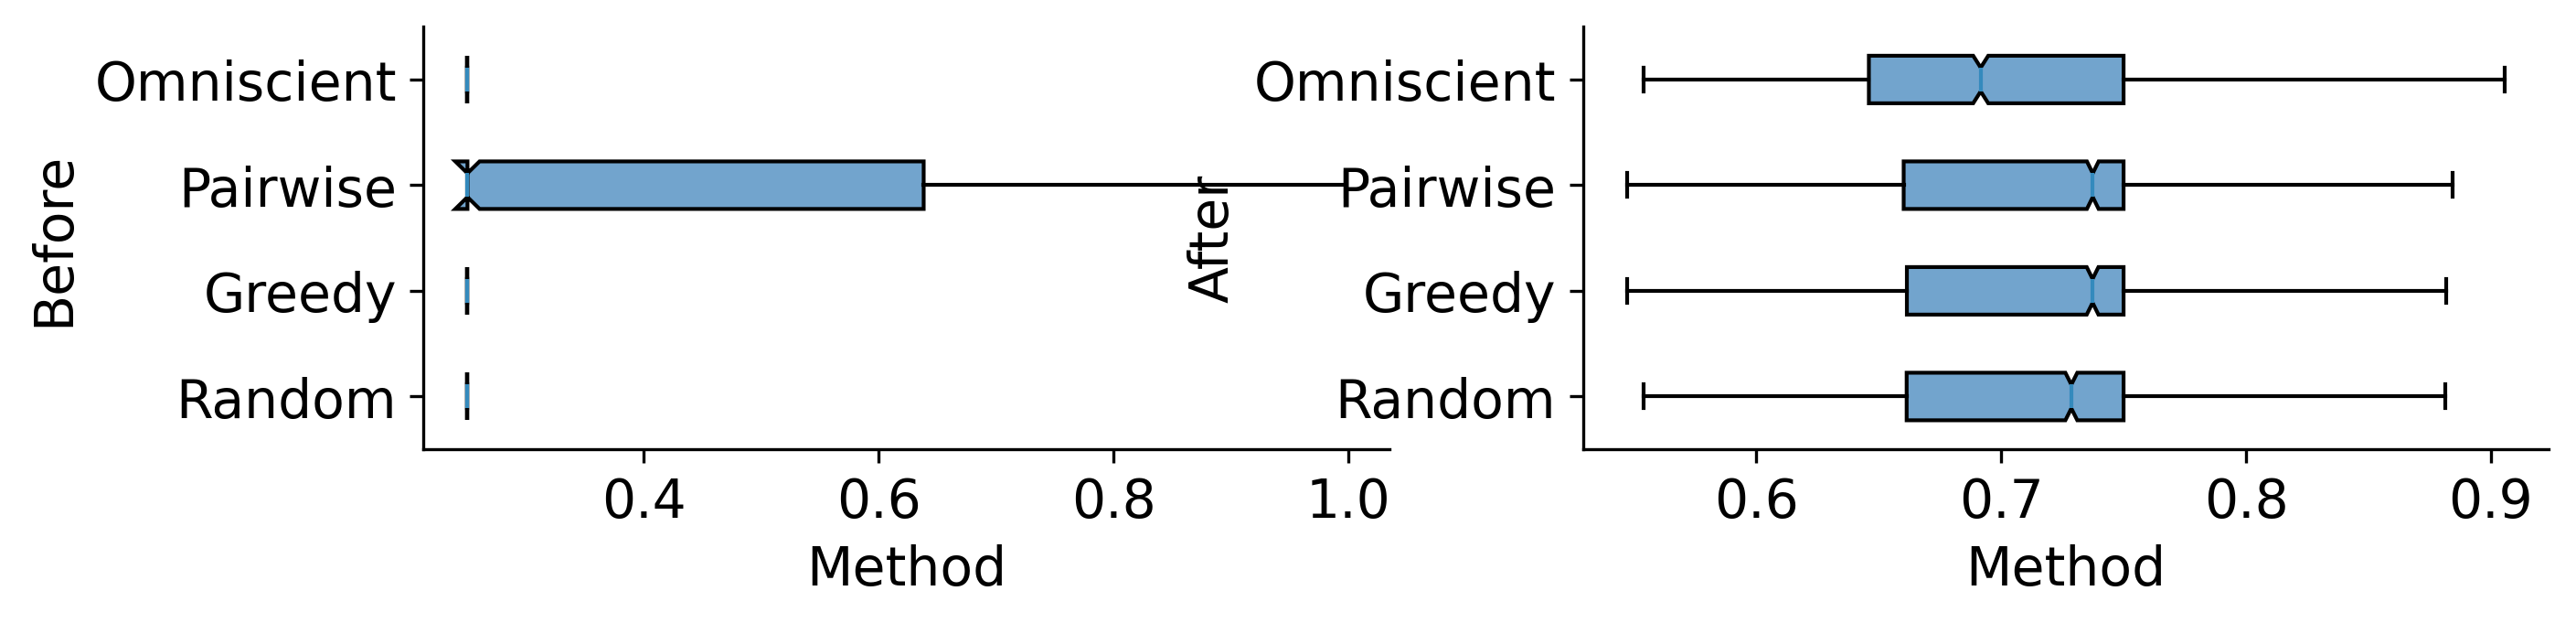

In [30]:

# Create plot with box plots or KDE
plot_dimensions = (1, 2)
x_labels = [["Method", "Method"]]
y_labels = [["Before", "After"]]

overall_format = {
    'figsize': (10, 2),
    'style_size': 'paper',
    'hide_spines': True,
}

fig, ax = create_axes(plot_dimensions, overall_format, x_labels=x_labels, y_labels=y_labels)

# Prepare data for plotting
before_data = [before_utilities[m] for m in methods]
after_data = [after_utilities[m] for m in methods]

# Box-whisker plots
box_format = {
    'color_palette': 'six_color',
}

plot_box_whisker(ax[0][0], before_data, method_labels, box_format)
plot_box_whisker(ax[0][1], after_data, method_labels, box_format)

fig.savefig("../../results/figures/switcher_utility_distribution.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [31]:
# Get results from the new provider experiment
results = get_results_matching_parameters("dynamic", "", {'new_provider': True, 'num_patients': 1225})
params = results[0]['parameters']

# Load patient and provider data
patient_file = f"../../data/patient_data_{params['seed']}_{params['num_patients']}_{params['num_providers']}_comorbidity.json"
provider_file = f"../../data/provider_data_{params['seed']}_{params['num_patients']}_{params['num_providers']}_comorbidity.json"

with open(patient_file, 'r') as f:
    patient_data = json.load(f)
with open(provider_file, 'r') as f:
    provider_data = json.load(f)

patient_zipcodes = [p['location'] for p in patient_data]

# Get the new provider's location for each trial
method = 'omniscient_optimal'  # Choose which method to visualize
new_providers_key = f"{method}_new_providers"
new_providers = results[0][new_providers_key]  # Shape: (seeds, trials)

# Get the most common new provider (or first one)
new_provider_idx = new_providers[0][0]  # First seed, first trial
new_provider_zipcode = provider_data[new_provider_idx]['ZIP Code'][:5]  # Take first 5 digits
new_provider_city = provider_data[new_provider_idx]['City/Town']

print(f"New provider location: {new_provider_city}, ZIP {new_provider_zipcode}")

# Calculate match rates by zipcode before and after
def calculate_match_rates_before_after(method, patient_zipcodes, num_providers):
    """Calculate match rate by zipcode for before/after new provider"""
    matches_before_by_zipcode = {}
    matches_after_by_zipcode = {}
    
    utilities_key = f"{method}_patient_utilities"
    chosen_providers_key = f"{method}_chosen_providers"
    
    utilities = results[0][utilities_key]  # Shape: (seeds, trials, patients, 2)
    chosen_providers = results[0][chosen_providers_key]  # Shape: (seeds, trials, patients, 2)
    s = []
    t = []
    for seed_idx in range(len(utilities)):
        for trial_idx in range(len(utilities[seed_idx])):
            for patient_idx in range(len(utilities[seed_idx][trial_idx])):
                zipcode = patient_zipcodes[patient_idx]
                
                if zipcode not in matches_before_by_zipcode:
                    matches_before_by_zipcode[zipcode] = []
                    matches_after_by_zipcode[zipcode] = []
                
                # Before: check if provider is in [0, num_providers-1]
                provider_before = chosen_providers[seed_idx][trial_idx][patient_idx][0]
                matched_before = (provider_before >= 0 and provider_before < num_providers)
                
                # After: check if provider is in [0, num_providers] (includes new provider at index num_providers)
                provider_after = chosen_providers[seed_idx][trial_idx][patient_idx][1]
                matched_after = (provider_after >= 0 and provider_after < num_providers)
                
                if provider_after != provider_before:
                    t.append(provider_after)
                    s.append(provider_before)

                matches_before_by_zipcode[zipcode].append(1 if matched_before else 0)
                matches_after_by_zipcode[zipcode].append(1 if matched_after else 0)
    
    # Calculate match rates
    match_rate_before = {z: np.mean(matches_before_by_zipcode[z]) for z in matches_before_by_zipcode}
    match_rate_after = {z: np.mean(matches_after_by_zipcode[z]) for z in matches_after_by_zipcode}
    match_rate_change = {z: match_rate_after[z] - match_rate_before[z] for z in match_rate_before}
    print(Counter(s))
    print(Counter(t))
    return match_rate_before, match_rate_after, match_rate_change
match_rate_before, match_rate_after, match_rate_change = calculate_match_rates_before_after(
    method, patient_zipcodes, params['num_providers']
)

# Load CT zipcode shapefile
ct_zipcodes = gpd.read_file("../../data/ct.geojson")

# Add data to geodataframe
ct_zipcodes["match_rate_before"] = [match_rate_before.get(z, -1) for z in ct_zipcodes["ZCTA5CE10"]]
ct_zipcodes["match_rate_after"] = [match_rate_after.get(z, -1) for z in ct_zipcodes["ZCTA5CE10"]]
ct_zipcodes["match_rate_change"] = [match_rate_change.get(z, 0) for z in ct_zipcodes["ZCTA5CE10"]]

# Get the new provider's geometry for zooming
new_provider_geom = ct_zipcodes[ct_zipcodes["ZCTA5CE10"] == new_provider_zipcode]



New provider location: BLOOMFIELD, ZIP 06002
Counter({700: 2567, 235: 16, 450: 13, 584: 7, 695: 5, 60: 5, 246: 5, 512: 4, 340: 4, 169: 4, 170: 4, 382: 4, 244: 4, 555: 3, 533: 3, 45: 3, 383: 3, 499: 3, 456: 3, 656: 3, 617: 3, 206: 3, 310: 3, 612: 3, 439: 3, 72: 2, 165: 2, 79: 2, 29: 2, 219: 2, 321: 2, 650: 2, 379: 2, 159: 2, 101: 2, 412: 2, 478: 2, 367: 2, 5: 2, 176: 2, 261: 2, 240: 2, 278: 2, 442: 2, 290: 2, 11: 2, 466: 2, 631: 2, 666: 2, 273: 2, 547: 2, 438: 2, 256: 2, 138: 2, 254: 2, 94: 2, 490: 1, 663: 1, 292: 1, 474: 1, 332: 1, 443: 1, 451: 1, 6: 1, 440: 1, 463: 1, 59: 1, 445: 1, 202: 1, 55: 1, 608: 1, 449: 1, 48: 1, 453: 1, 366: 1, 504: 1, 418: 1, 346: 1, 515: 1, 330: 1, 573: 1, 604: 1, 271: 1, 475: 1, 239: 1, 150: 1, 129: 1, 527: 1, 642: 1, 657: 1, 519: 1, 267: 1, 51: 1, 249: 1, 544: 1, 209: 1, 483: 1, 275: 1, 50: 1, 447: 1, 57: 1, 84: 1, 198: 1, 426: 1, 618: 1, 522: 1, 200: 1, 317: 1, 187: 1, 233: 1, 591: 1, 126: 1, 272: 1, 374: 1, 627: 1, 570: 1, 349: 1, 97: 1, 473: 1, 545: 1, 

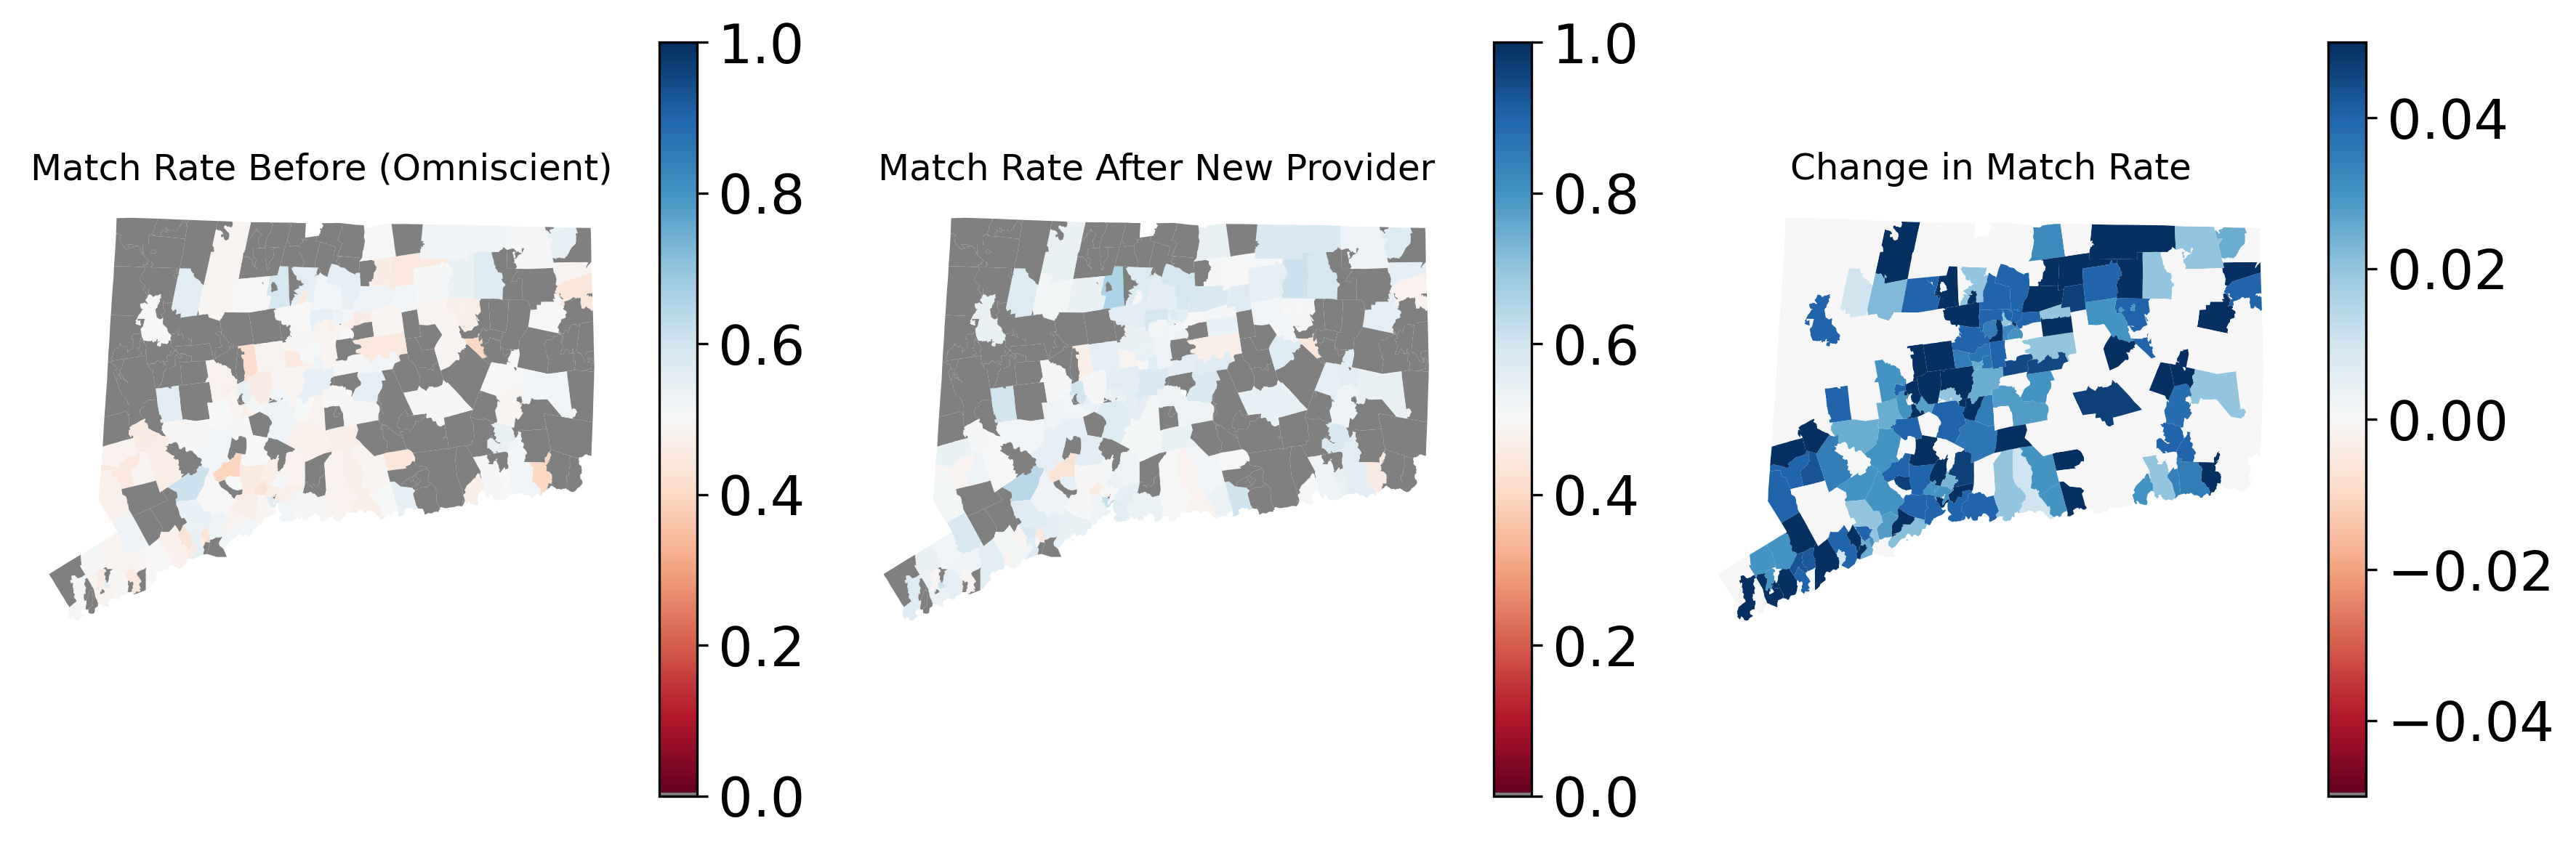

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))

# Colormap
cmap_blue_red = mcolors.ListedColormap(["grey"] + plt.cm.RdBu_r(np.linspace(1, 0, 256)).tolist())
cmap_change = cmap_blue_red  # Red=decrease, Yellow=no change, Green=increase

# Plot 1: Match Rate Before
ct_zipcodes.plot(column="match_rate_before", ax=axes[0], legend=True, cmap=cmap_blue_red,
                 vmin=0, vmax=1, missing_kwds={"color": "lightgrey"})
axes[0].set_title(f"Match Rate Before (Omniscient)")
axes[0].axis('off')

# Plot 2: Match Rate After
ct_zipcodes.plot(column="match_rate_after", ax=axes[1], legend=True, cmap=cmap_blue_red,
                 vmin=0, vmax=1, missing_kwds={"color": "lightgrey"})
axes[1].set_title(f"Match Rate After New Provider")
axes[1].axis('off')

# Plot 3: Change in Match Rate
ct_zipcodes.plot(column="match_rate_change", ax=axes[2], legend=True, cmap=cmap_change,
                 vmin=-0.05, vmax=0.05, missing_kwds={"color": "lightgrey"})
axes[2].set_title(f"Change in Match Rate")
axes[2].axis('off')

# Mark new provider location on all plots
if not new_provider_geom.empty:
    for ax in axes:
        new_provider_geom.plot(ax=ax, color='none', edgecolor='black', linewidth=3)
        centroid = new_provider_geom.geometry.centroid.iloc[0]
        ax.plot(centroid.x, centroid.y, 'r*', markersize=20, label='New Provider')

# Optionally zoom in around the new provider
if not new_provider_geom.empty:
    bounds = new_provider_geom.total_bounds  # minx, miny, maxx, maxy
    buffer = 0.3  # Adjust zoom level
    for ax in axes:
        ax.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
        ax.set_ylim(bounds[1] - buffer, bounds[3] + buffer)

plt.tight_layout()
fig.savefig("../../results/figures/geographic_new_provider_impact.pdf", dpi=300, bbox_inches='tight')
plt.show()


In [33]:

# Methods and labels
methods = ['random', 'greedy', 'lp', 'omniscient_optimal']
method_labels = ['Random', 'Greedy', 'Pairwise', 'Omniscient']

# === Plot 1: Patient/Provider Ratio ===
num_patients_values = [800,1200,1600,2000]
num_providers = 700

# Store results for each method
ratio_avg_utilities = {method: [] for method in methods}
ratio_avg_utilities_std = {method: [] for method in methods}

for num_patients in num_patients_values:
    results = get_results_matching_parameters("ablations", "", {
        'num_patients': num_patients,
        'num_providers': num_providers,
        'noise': 0.1
    })

    
    for method in methods:
        utilities_key = f"{method}_patient_utilities"
        utilities = results[0][utilities_key]
        
        # Flatten: [seeds][trials][patients]
        all_utilities = []
        for seed_idx in range(len(utilities)):
            for trial_idx in range(len(utilities[seed_idx])):
                all_utilities.extend(utilities[seed_idx][trial_idx])
        
        ratio_avg_utilities[method].append(np.mean(all_utilities))
        ratio_avg_utilities_std[method].append(np.std(all_utilities) / np.sqrt(len(all_utilities)))

# === Plot 2: Noise ===
noise_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

# Store results for each method
noise_avg_utilities = {method: [] for method in methods}
noise_avg_utilities_std = {method: [] for method in methods}

for noise in noise_values:
    results = get_results_matching_parameters("ablations", "", {
        'num_patients': 1225,
        'num_providers': 700,
        'noise': noise
    })
    
    for method in methods:
        utilities_key = f"{method}_patient_utilities"
        utilities = results[0][utilities_key]
        
        # Flatten: [seeds][trials][patients]
        all_utilities = []
        for seed_idx in range(len(utilities)):
            for trial_idx in range(len(utilities[seed_idx])):
                all_utilities.extend(utilities[seed_idx][trial_idx])
        
        noise_avg_utilities[method].append(np.mean(all_utilities))
        noise_avg_utilities_std[method].append(np.std(all_utilities) / np.sqrt(len(all_utilities)))


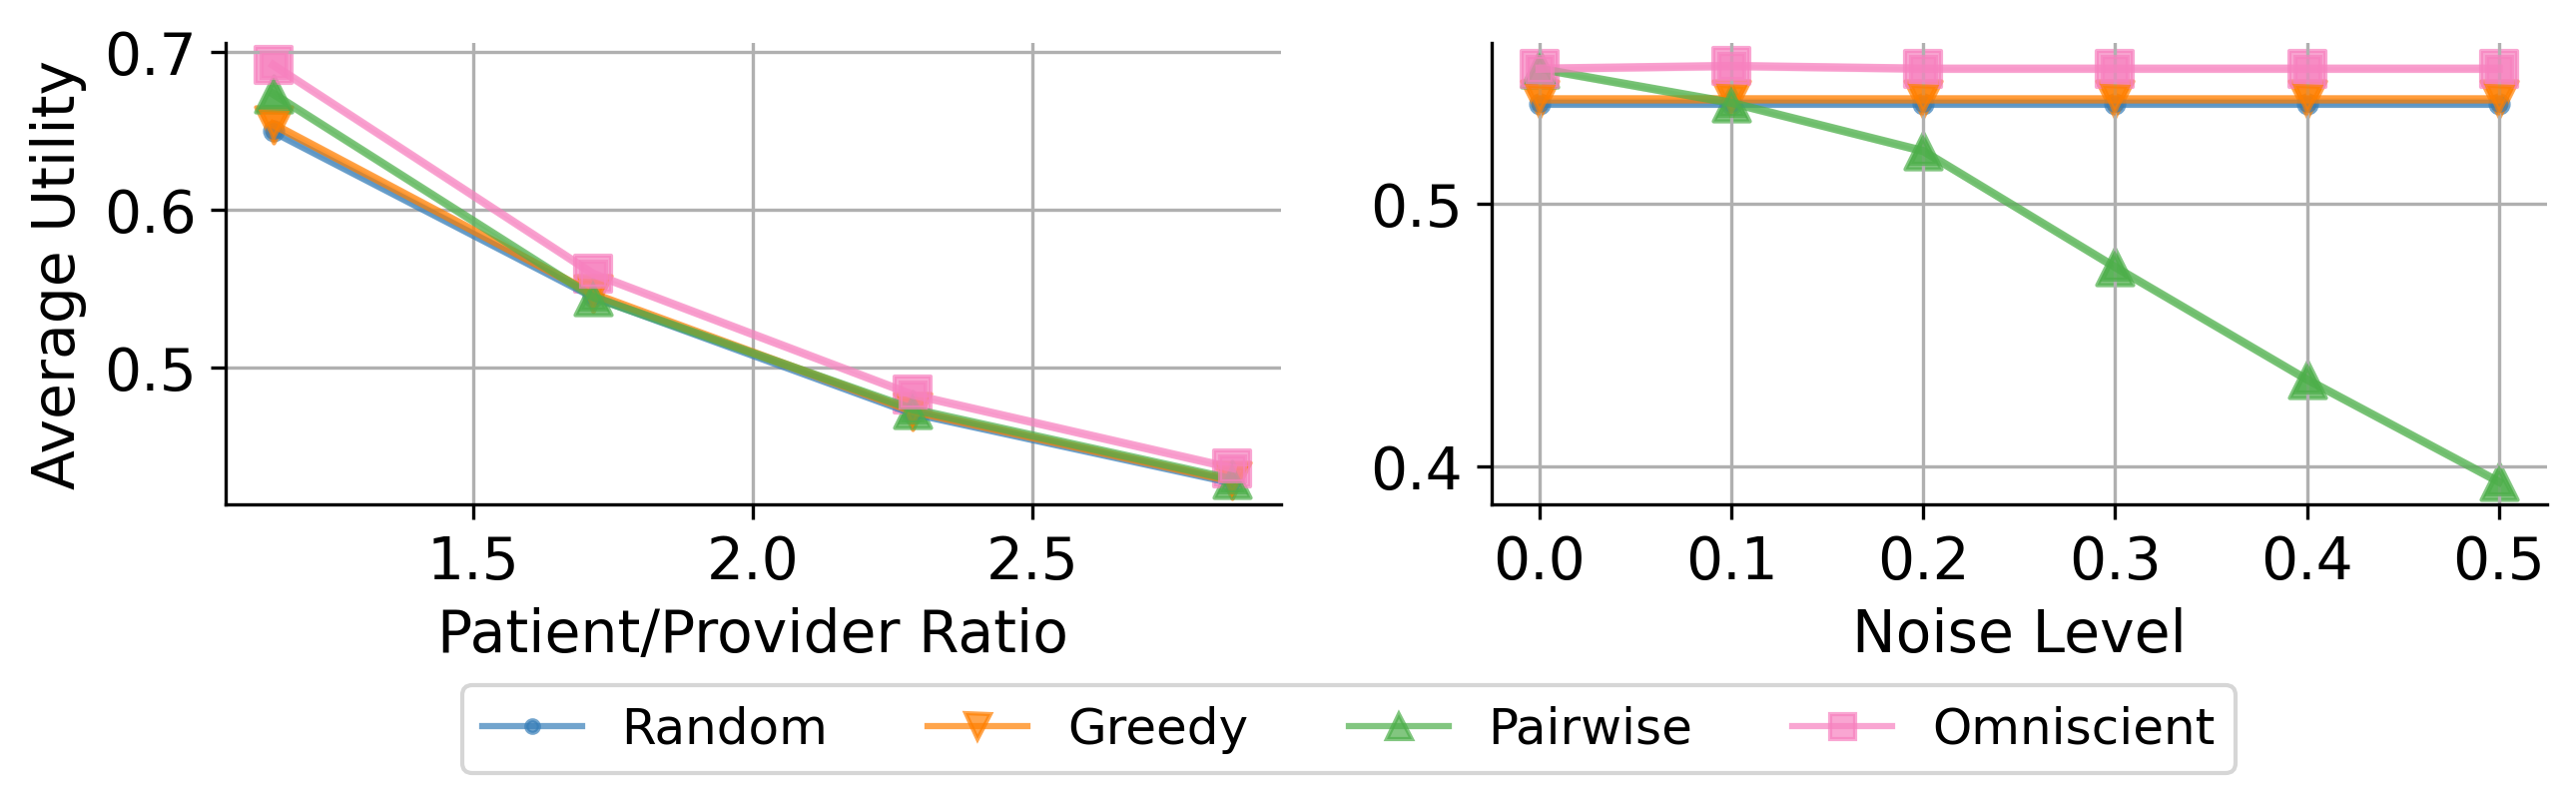

In [34]:
plot_dimensions = (1, 2)
x_labels = [["Patient/Provider Ratio", "Noise Level"]]
y_labels = [["Average Utility", ""]]

# Calculate ratios for x-axis
ratios = [n / num_providers for n in num_patients_values]

overall_format = {
    'figsize': (10, 2),
    'style_size': 'paper',
    'hide_spines': True,
    'has_grid': True,
}

fig, ax = create_axes(plot_dimensions, overall_format, x_labels=x_labels, y_labels=y_labels)

# Plot 1: Patient/Provider Ratio
line_format = {
    'color_palette': 'six_color',
    'linewidth': 2,
}

x_values_ratio = [ratios for _ in methods]
y_values_ratio = [ratio_avg_utilities[method] for method in methods]
y_confidence_ratio = [ratio_avg_utilities_std[method] for method in methods]

plot_line(ax[0][0], x_values_ratio, y_values_ratio, y_confidence_ratio, method_labels, line_format)
plot_scatter(ax[0][0], x_values_ratio, y_values_ratio, [], {'color_palette': 'six_color', 'size': 75})

# Plot 2: Noise
x_values_noise = [noise_values for _ in methods]
y_values_noise = [noise_avg_utilities[method] for method in methods]
y_confidence_noise = [noise_avg_utilities_std[method] for method in methods]

plot_line(ax[0][1], x_values_noise, y_values_noise, y_confidence_noise, method_labels, line_format)
plot_scatter(ax[0][1], x_values_noise, y_values_noise, [], {'color_palette': 'six_color', 'size': 75})

# Add legend
legend_format = {
    'style_size': 'paper',
    'type': 'is_global',
    'loc': 'upper center',
    'ncol': 4,
    'bbox_to_anchor': (0.5, -0.15),
    'show_point': True
}
create_legend(fig, ax, plot_dimensions, legend_format)

fig.savefig("../../results/figures/ablation_study.pdf", dpi=300, bbox_inches='tight')
plt.show()


In [35]:
methods = ['random', 'greedy', 'lp', 'omniscient_optimal']
method_labels = ['Random', 'Greedy', 'Pairwise', 'Omniscient']

# === Get Performance vs Average Distance ===
average_distance_values = [1, 5, 10, 15, 20, 25, 30]

# Store results for each method
distance_avg_utilities = {method: [] for method in methods}
distance_avg_utilities_std = {method: [] for method in methods}

for avg_dist in average_distance_values:
    print(avg_dist)
    results = get_results_matching_parameters("ablations", "", {
        'num_patients': 1225,
        'num_providers': 700,
        'noise': 0.1,
        'average_distance': avg_dist
    })
    
    for method in methods:
        utilities_key = f"{method}_patient_utilities"
        utilities = results[0][utilities_key]
        
        # Flatten: [seeds][trials][patients]
        all_utilities = []
        for seed_idx in range(len(utilities)):
            for trial_idx in range(len(utilities[seed_idx])):
                all_utilities.extend(utilities[seed_idx][trial_idx])
        
        distance_avg_utilities[method].append(np.mean(all_utilities))
        distance_avg_utilities_std[method].append(np.std(all_utilities) / np.sqrt(len(all_utilities)))

# === Get Geographic Data ===
def calculate_match_rates_by_zipcode(results, patient_zipcodes, num_providers, method='omniscient_optimal'):
    """Calculate match rate by zipcode"""
    matches_by_zipcode = {}
    
    utilities_key = f"{method}_patient_utilities"
    chosen_providers_key = f"{method}_chosen_providers"
    
    utilities = results[0][utilities_key]
    chosen_providers = results[0][chosen_providers_key]
    
    for seed_idx in range(len(utilities)):
        for trial_idx in range(len(utilities[seed_idx])):
            for patient_idx in range(len(utilities[seed_idx][trial_idx])):
                zipcode = patient_zipcodes[patient_idx]
                provider = chosen_providers[seed_idx][trial_idx][patient_idx]
                
                if zipcode not in matches_by_zipcode:
                    matches_by_zipcode[zipcode] = []
                
                # Check if matched (provider in [0, num_providers-1])
                matched = (provider >= 0 and provider < num_providers)
                matches_by_zipcode[zipcode].append(1 if matched else 0)
    
    # Calculate match rates
    match_rate = {z: np.mean(matches_by_zipcode[z]) for z in matches_by_zipcode}
    return match_rate

# Get results for distance=1 and distance=30
results_dist1 = get_results_matching_parameters("ablations", "", {
    'num_patients': 300,
    'num_providers': 150,
    'noise': 0.1,
    'average_distance': 1
})

results_dist30 = get_results_matching_parameters("ablations", "", {
    'num_patients': 300,
    'num_providers': 150,
    'noise': 0.1,
    'average_distance': 30
})

# Load patient data
params = results_dist1[0]['parameters']
patient_file = f"../../data/patient_data_{params['seed']}_{params['num_patients']}_{params['num_providers']}_comorbidity.json"
with open(patient_file, 'r') as f:
    patient_data = json.load(f)
patient_zipcodes = [p['location'] for p in patient_data]

# Calculate match rates for both distances (using omniscient policy)
match_rate_dist1 = calculate_match_rates_by_zipcode(results_dist1, patient_zipcodes, params['num_providers'], 'omniscient_optimal')
match_rate_dist30 = calculate_match_rates_by_zipcode(results_dist30, patient_zipcodes, params['num_providers'], 'omniscient_optimal')

# Calculate change
match_rate_change = {z: match_rate_dist30.get(z, 0) - match_rate_dist1.get(z, 0) 
                     for z in set(list(match_rate_dist1.keys()) + list(match_rate_dist30.keys()))}

# Load CT zipcode shapefile
ct_zipcodes = gpd.read_file("../../data/ct.geojson")

# Add data to geodataframe
ct_zipcodes["match_rate_dist1"] = [match_rate_dist1.get(z, -1) for z in ct_zipcodes["ZCTA5CE10"]]
ct_zipcodes["match_rate_dist30"] = [match_rate_dist30.get(z, -1) for z in ct_zipcodes["ZCTA5CE10"]]
ct_zipcodes["match_rate_change"] = [match_rate_change.get(z, 0) for z in ct_zipcodes["ZCTA5CE10"]]



1
5
10
15
20
25
30


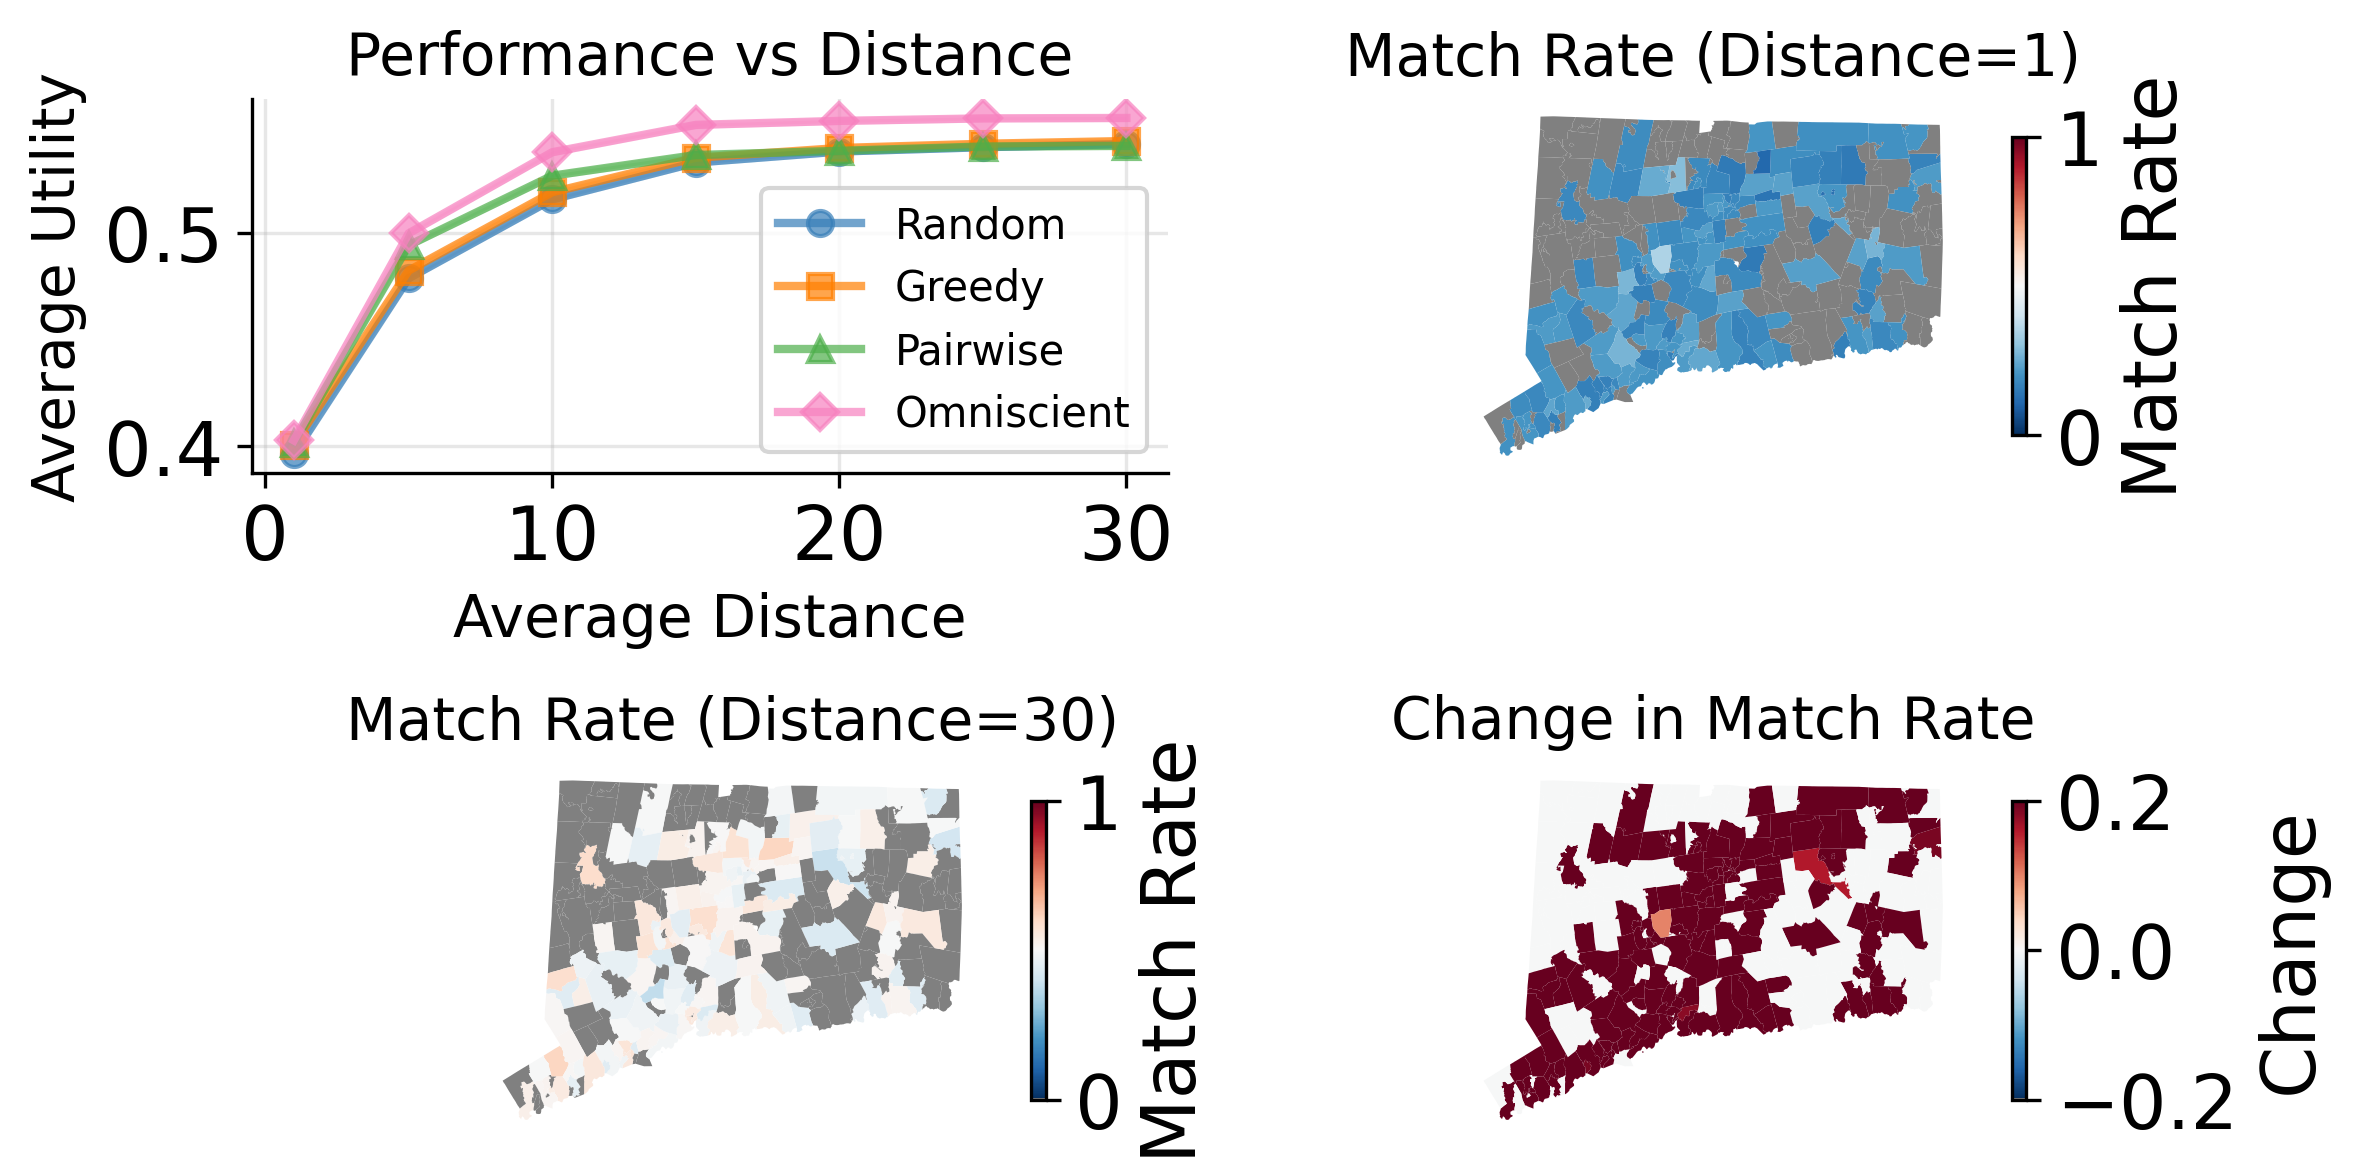

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(8, 4))

# Plot 1: Performance Line Graph
line_format = {
    'color_palette': 'six_color',
    'linewidth': 2,
}

x_values_distance = [average_distance_values for _ in methods]
y_values_distance = [distance_avg_utilities[method] for method in methods]
y_confidence_distance = [distance_avg_utilities_std[method] for method in methods]

for i, method in enumerate(methods):
    axes[0][0].plot(x_values_distance[i], y_values_distance[i], label=method_labels[i], 
                 linewidth=2, color=color_schemes['six_color'][i], marker=markers[i])
    axes[0][0].fill_between(x_values_distance[i], 
                         np.array(y_values_distance[i]) - np.array(y_confidence_distance[i]),
                         np.array(y_values_distance[i]) + np.array(y_confidence_distance[i]),
                         alpha=0.2, color=color_schemes['six_color'][i])

axes[0][0].set_xlabel("Average Distance", fontsize=14)
axes[0][0].set_ylabel("Average Utility", fontsize=14)
axes[0][0].set_title("Performance vs Distance", fontsize=14)
axes[0][0].spines['top'].set_visible(False)
axes[0][0].spines['right'].set_visible(False)
axes[0][0].grid(True, alpha=0.3)
axes[0][0].legend(fontsize=10, loc='best')

# Colormap
cmap_blue_red = mcolors.ListedColormap(["grey"] + plt.cm.RdBu_r(np.linspace(0, 1, 256)).tolist())
cmap_change = plt.cm.RdYlGn  # Red=decrease, Green=increase

# Plot 2: Distance=1
ct_zipcodes.plot(column="match_rate_dist1", ax=axes[0][1], legend=True, cmap=cmap_blue_red,
                 vmin=0, vmax=1, missing_kwds={"color": "lightgrey"},
                 legend_kwds={'label': 'Match Rate', 'shrink': 0.8})
axes[0][1].set_title("Match Rate (Distance=1)", fontsize=14)
axes[0][1].axis('off')

# Plot 3: Distance=30
ct_zipcodes.plot(column="match_rate_dist30", ax=axes[1][0], legend=True, cmap=cmap_blue_red,
                 vmin=0, vmax=1, missing_kwds={"color": "lightgrey"},
                 legend_kwds={'label': 'Match Rate', 'shrink': 0.8})
axes[1][0].set_title("Match Rate (Distance=30)", fontsize=14)
axes[1][0].axis('off')

# Plot 4: Change
ct_zipcodes.plot(column="match_rate_change", ax=axes[1][1], legend=True, cmap=cmap_blue_red,
                 vmin=-0.2, vmax=0.2, missing_kwds={"color": "lightgrey"},
                 legend_kwds={'label': 'Change', 'shrink': 0.8})
axes[1][1].set_title("Change in Match Rate", fontsize=14)
axes[1][1].axis('off')

plt.tight_layout()
fig.savefig("../../results/figures/distance_analysis_combined.pdf", dpi=300, bbox_inches='tight')
plt.show()


## Old Plots

### Performance Comparison

In [9]:
methods = ['random','greedy','lp','group_based','gradient_descent_fast']
method_labels = ["Random","Greedy","Pairwise","Group-Based","Gradient Descent"]

# WINE Plots

## Synthetic Experiments

In [ ]:
x_values = [2,3,4,5]
dataset = 'small'

provider_y_values = [[] for i in range(len(methods))]
provider_y_confidences = [[] for i in range(len(methods))]
baseline_params = {'num_patients': 2, 'fairness_weight': 0}
for i in range(len(x_values)):
    baseline_params['num_providers'] = x_values[i] 

    results = get_results_matching_parameters(dataset,"",baseline_params)
    aggregate_data = aggregate_normalize_data(results,baseline="optimal")
    for method in range(len(method_labels)):
        provider_y_values[method].append(aggregate_data['{}_utilities'.format(methods[method])][0])
        provider_y_confidences[method].append(aggregate_data['{}_utilities'.format(methods[method])][1]/len(results)**.5)

In [ ]:
patient_y_values = [[] for i in range(len(methods))]
patient_y_confidences = [[] for i in range(len(methods))]
baseline_params = {'num_providers': 2, 'fairness_weight': 0}
for i in range(len(x_values)):
    baseline_params['num_patients'] = x_values[i] 

    results = get_results_matching_parameters(dataset,"",baseline_params)
    aggregate_data = aggregate_normalize_data(results,baseline="optimal")
    for method in range(len(method_labels)):
        patient_y_values[method].append(aggregate_data['{}_utilities'.format(methods[method])][0])
        patient_y_confidences[method].append(aggregate_data['{}_utilities'.format(methods[method])][1]/len(results)**.5)

In [ ]:
np.min(provider_y_values[1:]),np.min(patient_y_values[2])

In [ ]:
plot_dimensions = (1,2)
x_labels = [["#Providers (M) with N=2","#Patients (N) with M=2"]]
y_labels = [["Approx. Ratio",""]]
sup_y_label = ""
overall_format = {'figsize':(8,1.5),
    'style_size': style_size,
    'x_ticks': [[[[2,3,4,5],[2,3,4,5]],[[2,3,4,5],[2,3,4,5]]]],
    'y_ticks': [[[[0.4,0.6,0.8,1.0],[0.4,0.6,0.8,1.0]],[[0.4,0.6,0.8,1.0],[0.4,0.6,0.8,1.0]]]],
    'y_lim': [[[0.3,1.05],[0.3,1.05]]],
    'has_grid': True, 
}

fig,ax = create_axes(plot_dimensions,overall_format,x_labels=x_labels,y_labels=y_labels,sup_y_label=sup_y_label)

line_format = {'color_palette': 'six_color', 'size': 75}
plot_line(ax[0][0],[x_values for i in range(len(provider_y_values))],provider_y_values,provider_y_confidences,method_labels,line_format)
plot_scatter(ax[0][0],[x_values for i in range(len(provider_y_values))],provider_y_values,[],line_format)

plot_line(ax[0][1],[x_values for i in range(len(patient_y_values))],patient_y_values,patient_y_confidences,method_labels,line_format)
plot_scatter(ax[0][1],[x_values for i in range(len(patient_y_confidences))],patient_y_values,[],line_format)

legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'lower left', 'ncol': 3, 'bbox_to_anchor': (0.09,-0.8), 'show_point': True, 'fontsize': 14}
create_legend(fig,ax,plot_dimensions,legend_format)

fig.savefig("../../results/figures/small_patient_provider.pdf",dpi=300, bbox_inches='tight')

In [ ]:
top_choice_probs = [0.1,0.25,0.5,0.75,0.9]
utility_functions = ['uniform','normal']
dataset = "policy_comparison"

x_value_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(2)]
y_value_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(2)]
y_confidence_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(2)]

baseline_params = {'num_patients': 25, 'num_providers': 25, 'max_menu_size': 50, 'fairness_weight': 0}
for i in range(len(y_value_matrix)):
    for j in range(len(y_value_matrix[i])):
        baseline_params['utility_function'] = utility_functions[i]
        baseline_params['top_choice_prob'] = top_choice_probs[j]

        results = get_results_matching_parameters(dataset,"",baseline_params)
        aggregate_data = aggregate_normalize_data(results,baseline="random")
        x_value_matrix[i][j] = [aggregate_data['{}_minimums'.format(method)][0] for method in methods]
        y_value_matrix[i][j] = [aggregate_data['{}_utilities'.format(method)][0] for method in methods]
        y_confidence_matrix[i][j] = [aggregate_data['{}_utilities'.format(method)][1]/((len(results))**.5) for method in methods]

In [ ]:
(y_value_matrix[-1][-1])[1]/(y_value_matrix[-1][-1])[2]

In [ ]:
np.array(y_value_matrix)[0][-1][-1]/np.array(y_value_matrix)[0][-1][-2], np.array(y_value_matrix)[1][-1][1]/np.array(y_value_matrix)[1][-1][-2]

In [ ]:
(y_value_matrix[0][-1])[3]/(y_value_matrix[0][-1])[1],(y_value_matrix[-1][-1])[3]/(y_value_matrix[-1][-1])[1]

In [ ]:
(np.array(y_value_matrix)[:,:,3])/(np.array(y_value_matrix)[:,:,1])

In [ ]:
(np.array(y_value_matrix)[:,:,3])/np.max(y_value_matrix,axis=2)

In [ ]:
np.array(y_value_matrix)[:,:,2]/np.max(y_value_matrix,axis=2)

In [ ]:
plot_dimensions = (2,5)
x_labels = [["","","","",""],["p=0.1","p=0.25","p=0.5","p=0.75","p=0.9"]]
y_labels = [["Uniform","","","",""],["Normal","","","",""]]
sup_y_label = "Norm. MQ"

overall_format = {'figsize':(10, 2),
    'style_size': style_size,
    'x_ticks': [[[[],[]] for i in range(5)] for i in range(2)],
    'y_lim': [[[0.7,1.4] for i in range(5)] for j in range(2)], 
    'y_ticks': [[[[],[]] if i != 0 else [[0.8,1,1.2],[0.8,1.0,1.2]] for i in range(5)] for i in range(2)],
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels,sup_y_label=sup_y_label)

bar_format = {'style_size': style_size,
    'color_palette': 'six_color'}

for i in range(2):
    for j in range(5):
        x_groups = [0,1,2,3,4]
        y_values = y_value_matrix[i][j]
        y_errors = y_confidence_matrix[i][j]
        labels = method_labels
        plot_bar(ax[i][j],x_groups,y_values,y_errors,labels,bar_format)

legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'upper right', 'ncol': 5, 'bbox_to_anchor': (0.915,-0.05)}
create_legend(fig,ax,plot_dimensions,legend_format)
fig.savefig("../../results/figures/policy_comparison.pdf",dpi=300, bbox_inches='tight')

In [ ]:
top_choice_probs = [0.1,0.25,0.5,0.75,0.9]
utility_functions = ['uniform','normal']
dataset = "policy_comparison"

x_value_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(2)]
y_value_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(2)]
y_confidence_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(2)]

baseline_params = {'num_patients': 25, 'num_providers': 25, 'max_menu_size': 50, 'fairness_weight': 0}
for i in range(len(y_value_matrix)):
    for j in range(len(y_value_matrix[i])):
        baseline_params['utility_function'] = utility_functions[i]
        baseline_params['top_choice_prob'] = top_choice_probs[j]

        results = get_results_matching_parameters(dataset,"",baseline_params)
        aggregate_data = aggregate_normalize_data(results,baseline="random")
        x_value_matrix[i][j] = [aggregate_data['{}_minimums'.format(method)][0] for method in methods]
        y_value_matrix[i][j] = [aggregate_data['{}_matches'.format(method)][0] for method in methods]
        y_confidence_matrix[i][j] = [aggregate_data['{}_matches'.format(method)][1]/((len(results))**.5) for method in methods]

In [ ]:
plot_dimensions = (2,5)
x_labels = [["","","","",""],["p=0.1","p=0.25","p=0.5","p=0.75","p=0.9"]]
y_labels = [["Uniform","","","",""],["Normal","","","",""]]
sup_y_label = "Norm. MR"

overall_format = {'figsize':(10, 2),
    'style_size': style_size,
    'x_ticks': [[[[],[]] for i in range(5)] for i in range(2)],
    'y_lim': [[[0.7,1.4] for i in range(5)] for j in range(2)], 
    'y_ticks': [[[[],[]] if i != 0 else [[0.8,1,1.2],[0.8,1.0,1.2]] for i in range(5)] for i in range(2)],
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels,sup_y_label=sup_y_label)

bar_format = {'style_size': style_size,
    'color_palette': 'six_color'}

for i in range(2):
    for j in range(5):
        x_groups = [0,1,2,3,4]
        y_values = y_value_matrix[i][j]
        y_errors = y_confidence_matrix[i][j]
        labels = method_labels
        plot_bar(ax[i][j],x_groups,y_values,y_errors,labels,bar_format)

legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'upper right', 'ncol': 5, 'bbox_to_anchor': (0.915,-0.05)}
create_legend(fig,ax,plot_dimensions,legend_format)
fig.savefig("../../results/figures/policy_comparison_matches.pdf",dpi=300, bbox_inches='tight')

In [ ]:
top_choice_probs = [0.1,0.3,0.5,0.7,0.9]
num_patients = [25,50,75,100,125,150,175,200]
utility_function = 'uniform'
dataset = "providers_patients"

y_value_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(8)]
y_confidence_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(8)]

baseline_params = {'num_patients': 25, 'num_providers': 25, 'max_menu_size': 300, 'utility_function': utility_function, 'fairness_weight': 0}
for i in range(len(y_value_matrix)):
    for j in range(len(y_value_matrix[i])):
        baseline_params['num_patients'] = num_patients[i]
        baseline_params['top_choice_prob'] = top_choice_probs[j]

        results = get_results_matching_parameters(dataset,"",baseline_params)
        aggregate_data = aggregate_normalize_data(results,baseline="random")
        y_value_matrix[i][j] = np.argmax([aggregate_data['{}_utilities'.format(method)][0] for method in methods])

In [ ]:
plt.figure(figsize=(5,2))
reference_patients = num_patients[0]
gaps = 1/2
for i in range(len(top_choice_probs)):
    for j in range(len(num_patients)):
        scaled_patients = num_patients[j]/reference_patients
        x = [scaled_patients-gaps,scaled_patients-gaps,scaled_patients+gaps,scaled_patients+gaps,scaled_patients-gaps]
        y = [top_choice_probs[i]-0.1,top_choice_probs[i]+0.1,top_choice_probs[i]+0.1,top_choice_probs[i]-0.1,top_choice_probs[i]-0.1]
        plt.fill(x, y, color=color_schemes['six_color'][y_value_matrix[j][i]],lw=0)

        if i<len(top_choice_probs)-1 and y_value_matrix[j][i]!=y_value_matrix[j][i+1]:
            plt.plot([scaled_patients-gaps,scaled_patients+gaps],[top_choice_probs[i]+0.1,top_choice_probs[i]+0.1],color='black')
        if j<len(num_patients)-1 and y_value_matrix[j][i]!=y_value_matrix[j+1][i]:
            plt.plot([scaled_patients+gaps,scaled_patients+gaps],[top_choice_probs[i]-0.1,top_choice_probs[i]+0.1],color='black')
    plt.ylim([0,1])
    plt.xlim([0.5,8.5])
plt.tick_params(axis='both',which='both',length=0,pad=10)
ax = plt.gca()  # Get the current Axes object
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)

plt.xlabel("Patient/Provider Ratio (N/M)",fontsize=14)
plt.ylabel("Match probability (p)",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.text(0.57,0.8,"Grp\nBsd",verticalalignment='center',fontsize=12)
plt.text(1.5,0.2,"Greedy",verticalalignment='center',fontsize=12)
plt.text(4,0.6,"Gradient Descent",verticalalignment='center',fontsize=12)
plt.savefig("../../results/figures/phase_diagram.pdf",dpi=300, bbox_inches='tight')

In [ ]:
top_choice_probs = [0.1,0.3,0.5,0.7,0.9]
num_patients = [25,50,75,100,125,150,175,200]
utility_function = 'normal'
dataset = "providers_patients"

y_value_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(8)]
y_confidence_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(8)]

baseline_params = {'num_patients': 25, 'num_providers': 25, 'max_menu_size': 300, 'utility_function': utility_function, 'fairness_weight': 0}
for i in range(len(y_value_matrix)):
    for j in range(len(y_value_matrix[i])):
        baseline_params['num_patients'] = num_patients[i]
        baseline_params['top_choice_prob'] = top_choice_probs[j]

        results = get_results_matching_parameters(dataset,"",baseline_params)
        aggregate_data = aggregate_normalize_data(results,baseline="random")
        y_value_matrix[i][j] = np.argmax([aggregate_data['{}_utilities'.format(method)][0] for method in methods])

In [ ]:
plt.figure(figsize=(5,2))
reference_patients = num_patients[0]
gaps = 1/2
for i in range(len(top_choice_probs)):
    for j in range(len(num_patients)):
        scaled_patients = num_patients[j]/reference_patients
        x = [scaled_patients-gaps,scaled_patients-gaps,scaled_patients+gaps,scaled_patients+gaps,scaled_patients-gaps]
        y = [top_choice_probs[i]-0.1,top_choice_probs[i]+0.1,top_choice_probs[i]+0.1,top_choice_probs[i]-0.1,top_choice_probs[i]-0.1]
        plt.fill(x, y, color=color_schemes['six_color'][y_value_matrix[j][i]],lw=0)

        if i<len(top_choice_probs)-1 and y_value_matrix[j][i]!=y_value_matrix[j][i+1]:
            plt.plot([scaled_patients-gaps,scaled_patients+gaps],[top_choice_probs[i]+0.1,top_choice_probs[i]+0.1],color='black')
        if j<len(num_patients)-1 and y_value_matrix[j][i]!=y_value_matrix[j+1][i]:
            plt.plot([scaled_patients+gaps,scaled_patients+gaps],[top_choice_probs[i]-0.1,top_choice_probs[i]+0.1],color='black')
    plt.ylim([0,1])
    plt.xlim([0.5,8.5])
plt.tick_params(axis='both',which='both',length=0,pad=10)
ax = plt.gca()  # Get the current Axes object
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)

plt.xlabel("Patient/Provider Ratio (N/M)",fontsize=14)
plt.ylabel("Match probability (p)",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.text(3.5,0.9,"Group Based.",verticalalignment='center',fontsize=12)
plt.text(1,0.1,"Greedy",verticalalignment='center',fontsize=12)
plt.text(3.5,0.6,"Gradient Descent",verticalalignment='center',fontsize=12)
plt.savefig("../../results/figures/phase_diagram_normal.pdf",dpi=300, bbox_inches='tight')

In [ ]:
top_choice_probs = [0.1,0.3,0.5,0.7,0.9]
num_patients = [25,50,75,100,125,150,175,200]
utility_function = 'uniform'
dataset = "providers_patients"

y_value_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(8)]
y_confidence_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(8)]

baseline_params = {'num_patients': 10, 'num_providers': 25, 'max_menu_size': 300, 'utility_function': utility_function, 'fairness_weight': 0}
for i in range(len(y_value_matrix)):
    for j in range(len(y_value_matrix[i])):
        baseline_params['num_patients'] = num_patients[i]
        baseline_params['top_choice_prob'] = top_choice_probs[j]

        results = get_results_matching_parameters(dataset,"",baseline_params)
        aggregate_data = aggregate_normalize_data(results,baseline="random")
        method_vals = [aggregate_data['{}_matches'.format(method)][0] for method in methods]
        y_value_matrix[i][j] = aggregate_data['{}_matches'.format('gradient_descent_fast')][0]/aggregate_data['{}_matches'.format('greedy')][0]
cmap = cm.get_cmap('viridis')
norm = Normalize(vmin=0.89, vmax=1.0)
colors = cmap(np.array(norm(y_value_matrix)))

In [ ]:
plt.figure(figsize=(5,2))
reference_patients = num_patients[0]
gaps = 1/2
for i in range(len(top_choice_probs)):
    for j in range(len(num_patients)):
        scaled_patients = num_patients[j]/reference_patients
        x = [scaled_patients-gaps,scaled_patients-gaps,scaled_patients+gaps,scaled_patients+gaps,scaled_patients-gaps]
        y = [top_choice_probs[i]-0.1,top_choice_probs[i]+0.1,top_choice_probs[i]+0.1,top_choice_probs[i]-0.1,top_choice_probs[i]-0.1]
        plt.fill(x, y, color=colors[j][i],lw=0)

        # if i<len(top_choice_probs)-1 and y_value_matrix[j][i]!=y_value_matrix[j][i+1]:
        #     plt.plot([scaled_patients-gaps,scaled_patients+gaps],[top_choice_probs[i]+0.1,top_choice_probs[i]+0.1],color='black')
        # if j<len(num_patients)-1 and y_value_matrix[j][i]!=y_value_matrix[j+1][i]:
        #     plt.plot([scaled_patients+gaps,scaled_patients+gaps],[top_choice_probs[i]-0.1,top_choice_probs[i]+0.1],color='black')
    plt.ylim([0,1])
    plt.xlim([0.5,8.5])
plt.tick_params(axis='both',which='both',length=0,pad=10)
ax = plt.gca()  # Get the current Axes object
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)

plt.xlabel("Patient/Provider Ratio (N/M)",fontsize=14)
plt.ylabel("Match probability (p)",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks([0,0.2,0.4,0.6,0.8,1.0],fontsize=14)
# plt.text(4,0.6,"Greedy",verticalalignment='center',fontsize=9.5)
# plt.text(0.5,0.1,"Rand.",verticalalignment='center',fontsize=9.5)
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label='Grad. Desc./Greedy MR',pad=0.1,ticks=[0.9, 0.95, 1],shrink=0.7)
cbar.set_label('Grad. Desc./Greedy MR', fontsize=12)
plt.savefig("../../results/figures/phase_diagram_match.pdf",dpi=300, bbox_inches='tight')

In [ ]:
top_choice_probs = [0.1,0.3,0.5,0.7,0.9]
num_patients = [25,50,75,100,125,150,175,200]
utility_function = 'normal'
dataset = "providers_patients"

y_value_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(8)]
y_confidence_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(8)]

baseline_params = {'num_patients': 10, 'num_providers': 25, 'max_menu_size': 300, 'utility_function': utility_function, 'fairness_weight': 0}
for i in range(len(y_value_matrix)):
    for j in range(len(y_value_matrix[i])):
        baseline_params['num_patients'] = num_patients[i]
        baseline_params['top_choice_prob'] = top_choice_probs[j]

        results = get_results_matching_parameters(dataset,"",baseline_params)
        aggregate_data = aggregate_normalize_data(results,baseline="random")
        method_vals = [aggregate_data['{}_matches'.format(method)][0] for method in methods]
        y_value_matrix[i][j] = aggregate_data['{}_matches'.format('gradient_descent_fast')][0]/aggregate_data['{}_matches'.format('greedy')][0]
cmap = cm.get_cmap('viridis')
norm = Normalize(vmin=0.89, vmax=1.0)
colors = cmap(np.array(norm(y_value_matrix)))

In [ ]:
plt.figure(figsize=(5,2))
reference_patients = num_patients[0]
gaps = 1/2
for i in range(len(top_choice_probs)):
    for j in range(len(num_patients)):
        scaled_patients = num_patients[j]/reference_patients
        x = [scaled_patients-gaps,scaled_patients-gaps,scaled_patients+gaps,scaled_patients+gaps,scaled_patients-gaps]
        y = [top_choice_probs[i]-0.1,top_choice_probs[i]+0.1,top_choice_probs[i]+0.1,top_choice_probs[i]-0.1,top_choice_probs[i]-0.1]
        plt.fill(x, y, color=colors[j][i],lw=0)
    plt.ylim([0,1])
    plt.xlim([0.5,8.5])
plt.tick_params(axis='both',which='both',length=0,pad=10)
ax = plt.gca()  # Get the current Axes object
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)

plt.xlabel("Patient/Provider Ratio (N/M)",fontsize=14)
plt.ylabel("Match probability (p)",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks([0,0.2,0.4,0.6,0.8,1.0],fontsize=14)
# plt.text(4,0.6,"Greedy",verticalalignment='center',fontsize=9.5)
# plt.text(0.5,0.1,"Rand.",verticalalignment='center',fontsize=9.5)
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label='Grad. Desc./Greedy MR',pad=0.1,ticks=[0.9, 0.95, 1],shrink=0.7)
cbar.set_label('Grad. Desc./Greedy MR', fontsize=12)
plt.savefig("../../results/figures/phase_diagram_normal_matches.pdf",dpi=300, bbox_inches='tight')

### Assumption Plots

In [ ]:
top_choice_prob = 0.5
assumption_relaxations = [["misspecified_theta_0.0","misspecified_theta_0.05","misspecified_theta_0.1","misspecified_theta_0.2"],["varied_p_0.0","varied_p_0.05","varied_p_0.1","varied_p_0.2"]]
utility_function = 'uniform'
dataset = "assumptions"

y_value_matrix = [[[0 for i in range(5)] for i in range(4)] for i in range(2)]
y_confidence_matrix = [[[0 for i in range(5)] for i in range(4)] for i in range(2)]

baseline_params = {'num_patients': 100, 'num_providers': 25, 'max_menu_size': 50,
                   'utility_function': utility_function, 'top_choice_prob': top_choice_prob}
for i in range(len(y_value_matrix)):
    for j in range(len(y_value_matrix[i])):
        baseline_params['assumption_relaxation'] = assumption_relaxations[i][j]

        results = get_results_matching_parameters(dataset,"",baseline_params)
        aggregate_data = aggregate_normalize_data(results,baseline="random")
        y_value_matrix[i][j] = [aggregate_data['{}_utilities'.format(method)][0] for method in methods]
        y_confidence_matrix[i][j] = [aggregate_data['{}_utilities'.format(method)][1]/((len(results))**.5) for method in methods]

In [ ]:
plot_dimensions = (2,4)
x_labels = [["","","",""],["0.0","0.05","0.1","0.2"]]
y_labels = [["$\\theta$","","",""],["$p$","","",""]]
sup_y_label = "Norm. MQ"
sup_x_label = "Noise Level"

overall_format = {'figsize':(10, 2),
    'style_size': style_size,
    'x_ticks': [[[[],[]] for i in range(4)] for i in range(2)],
    'y_lim': [[[0.5,1.4] for i in range(4)] for i in range(2)], 
    'y_ticks': [[[[],[]] if i != 0 else [[0.5,0.75,1.0,1.25],[0.5,0.75,1.0,1.25]] for i in range(4)] for i in range(2)],
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels,sup_y_label=sup_y_label,sup_x_label=sup_x_label,sup_x_label_loc=-0.1)

bar_format = {'style_size': style_size,
    'color_palette': 'six_color'}

for i in range(2):
    for j in range(4):
        x_groups = [0,1,2,3,4]
        y_values = y_value_matrix[i][j]
        y_errors = y_confidence_matrix[i][j]
        labels = method_labels
        plot_bar(ax[i][j],x_groups,y_values,y_errors,labels,bar_format)

legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'upper right', 'ncol': 5, 'bbox_to_anchor': (0.915,-0.1)}
create_legend(fig,ax,plot_dimensions,legend_format)
fig.savefig("../../results/figures/theta_p_shift.pdf",dpi=300, bbox_inches='tight')

In [ ]:
assumption_relaxations = ["dynamic_lp","dynamic_lp","","dynamic_lp",""]
order = ["custom","custom","proportional","custom","custom"]
provider_capacity = [1,1,1,1,2]
dataset = "assumptions"

y_value_matrix = [[0 for i in range(5)] for i in range(5)]
y_confidence_matrix = [[0 for i in range(5)] for i in range(5)]

baseline_params = {'num_patients': 100, 'num_providers': 25, 'max_menu_size': 50, 'fairness_weight': 0, 'provider_capacity': 2,'utility_function': 'uniform','top_choice_prob': 0.5}
for i in range(len(y_value_matrix)):
    baseline_params['order'] = order[i]
    baseline_params['provider_capacity'] = provider_capacity[i]
    baseline_params['assumption_relaxation'] = assumption_relaxations[i]

    results = get_results_matching_parameters(dataset,"",baseline_params)
    aggregate_data = aggregate_normalize_data(results,baseline="random")

    if i == 1:
        y_value_matrix[i] = [aggregate_data['{}_utilities'.format(method)][0] for method in methods + ['lp_dynamic']]
        y_confidence_matrix[i] = [aggregate_data['{}_utilities'.format(method)][1]/((len(results))**.5) for method in methods + ['lp_dynamic']]
    else:
        y_value_matrix[i] = [aggregate_data['{}_utilities'.format(method)][0] for method in methods]
        y_confidence_matrix[i] = [aggregate_data['{}_utilities'.format(method)][1]/((len(results))**.5) for method in methods]

        if i == 3:
            baseline_params['batch_size'] = 2
            baseline_params['assumption_relaxation'] = ""
            results = get_results_matching_parameters(dataset,"",baseline_params)
            aggregate_data = aggregate_normalize_data(results,baseline="random")
            y_value_matrix[i].append(aggregate_data['optimal_order_utilities'][0])
            y_confidence_matrix[i].append(aggregate_data['optimal_order_utilities'][1])
            baseline_params['batch_size'] = 1


In [ ]:
plot_dimensions = (1,5)
x_labels = [["Baseline","Dynamic","Order","Batched","Capacity"]]
y_labels = [["Norm. MQ","","","",""]]
sup_y_label = ""

overall_format = {'figsize':(12, 1.5),
    'style_size': style_size,
    'x_ticks': [[[[],[]] for i in range(5)] for i in range(5)],
    'y_lim': [[[0.5,1.4] for i in range(5)] for j in range(5)], 
    'y_ticks': [[[[],[]] if i != 0 else [[0.5,0.75,1,1.25],[0.5,0.75,1,1.25]] for i in range(5)] for i in range(5)],
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels,sup_y_label=sup_y_label)

bar_format = {'style_size': style_size,
    'color_palette': 'six_color'}

for i in range(5):
    x_groups = [0,1,2,3,4]
    y_values = y_value_matrix[i]
    y_errors = y_confidence_matrix[i]
    labels = method_labels
    if i == 3:
        x_groups.append(5)
        labels.append("Batched")
    plot_bar(ax[0][i],x_groups,y_values,y_errors,labels,bar_format)
    if i == 1:
        ax[0][i].hlines(y_value_matrix[i][-1],-0.1,1.1,linestyles='dashed',label='Dynamic Pairwise',color=np.array([0.9,0.05,0.05,1.0]))


handles, labels = ax[0][1].get_legend_handles_labels()
handles.append(ax[0][-2].get_legend_handles_labels()[0][-1])
labels.append(ax[0][-2].get_legend_handles_labels()[1][-1])
fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,-0.125),fontsize=14)
fig.savefig("../../results/figures/assumptions.pdf",dpi=300, bbox_inches='tight')

In [ ]:
provider_capacity = [1,2,3,4]
dataset = "assumptions"

y_value_matrix = [[0 for i in range(5)] for i in range(4)]
y_confidence_matrix = [[0 for i in range(5)] for i in range(4)]

baseline_params = {'num_patients': 100, 'num_providers': 25, 'max_menu_size': 50, 'fairness_weight': 0, 'provider_capacity': 2,'utility_function': 'uniform','top_choice_prob': 0.5,'assumption_relaxation': '', 'order': 'custom'}
for i in range(len(y_value_matrix)):
    baseline_params['provider_capacity'] = provider_capacity[i]
    if i == 0:
        baseline_params['assumption_relaxation'] = 'dynamic_lp'
    else:
        baseline_params['assumption_relaxation'] = ""

    results = get_results_matching_parameters(dataset,"",baseline_params)
    print(len(results))
    aggregate_data = aggregate_normalize_data(results,baseline="random")

    y_value_matrix[i] = [aggregate_data['{}_utilities'.format(method)][0] for method in methods]
    y_confidence_matrix[i] = [aggregate_data['{}_utilities'.format(method)][1]/((len(results))**.5) for method in methods]

In [ ]:
plot_dimensions = (1,4)
x_labels = [[1,2,3,4]]
y_labels = [["Norm. MQ","","","",""]]
sup_x_label = "Capacity"

overall_format = {'figsize':(12, 1.5),
    'style_size': style_size,
    'x_ticks': [[[[],[]] for i in range(5)] for i in range(5)],
    'y_lim': [[[0.5,1.4] for i in range(5)] for j in range(5)], 
    'y_ticks': [[[[],[]] if i != 0 else [[0.5,0.75,1,1.25],[0.5,0.75,1,1.25]] for i in range(5)] for i in range(5)],
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels,sup_x_label=sup_x_label,sup_x_label_loc=-0.25)

bar_format = {'style_size': style_size,
    'color_palette': 'six_color'}

for i in range(4):
    x_groups = [0,1,2,3,4]
    y_values = y_value_matrix[i]
    y_errors = y_confidence_matrix[i]
    labels = method_labels
    plot_bar(ax[0][i],x_groups,y_values,y_errors,labels,bar_format)


handles, labels = ax[0][1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=3,bbox_to_anchor=(0.5,-0.25),fontsize=14)
fig.savefig("../../results/figures/capacity.pdf",dpi=300, bbox_inches='tight')

In [ ]:
providers = [25,50,75,100]
dataset = "assumptions"

y_value_matrix = [[0 for i in range(5)] for i in range(4)]
y_confidence_matrix = [[0 for i in range(5)] for i in range(4)]

baseline_params = {'num_patients': 100, 'num_providers': 25, 'max_menu_size': 50, 'fairness_weight': 0, 'provider_capacity': 1,'utility_function': 'uniform','top_choice_prob': 0.5,'assumption_relaxation': '', 'order': 'custom'}
for i in range(len(y_value_matrix)):
    baseline_params['num_providers'] = providers[i]
    if i == 0:
        baseline_params['assumption_relaxation'] = 'dynamic_lp'
    else:
        baseline_params['assumption_relaxation'] = ""

    results = get_results_matching_parameters(dataset,"",baseline_params)
    print(len(results))
    aggregate_data = aggregate_normalize_data(results,baseline="random")

    y_value_matrix[i] = [aggregate_data['{}_utilities'.format(method)][0] for method in methods]
    y_confidence_matrix[i] = [aggregate_data['{}_utilities'.format(method)][1]/((len(results))**.5) for method in methods]

In [ ]:
plot_dimensions = (1,4)
x_labels = [providers]
y_labels = [["Norm. MQ","","","",""]]
sup_x_label = "#Providers"

overall_format = {'figsize':(12, 1.5),
    'style_size': style_size,
    'x_ticks': [[[[],[]] for i in range(5)] for i in range(5)],
    'y_lim': [[[0.5,1.4] for i in range(5)] for j in range(5)], 
    'y_ticks': [[[[],[]] if i != 0 else [[0.5,0.75,1,1.25],[0.5,0.75,1,1.25]] for i in range(5)] for i in range(5)],
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels,sup_x_label=sup_x_label,sup_x_label_loc=-0.25)

bar_format = {'style_size': style_size,
    'color_palette': 'six_color'}

for i in range(4):
    x_groups = [0,1,2,3,4]
    y_values = y_value_matrix[i]
    y_errors = y_confidence_matrix[i]
    labels = method_labels
    plot_bar(ax[0][i],x_groups,y_values,y_errors,labels,bar_format)


handles, labels = ax[0][1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=3,bbox_to_anchor=(0.5,-0.25),fontsize=14)
fig.savefig("../../results/figures/capacity_providers.pdf",dpi=300, bbox_inches='tight')

In [ ]:
assumptions = ["varied_std_{}".format(i) for i in [0,0.05,0.1,0.15,0.2,0.25]]
dataset = "assumptions"

y_value_matrix = [[0 for i in range(5)] for i in range(6)]
y_confidence_matrix = [[0 for i in range(5)] for i in range(6)]

baseline_params = {'num_patients': 100, 'num_providers': 25, 'max_menu_size': 50, 'fairness_weight': 0, 'provider_capacity': 1,'utility_function': 'normal','top_choice_prob': 0.5,'assumption_relaxation': '', 'order': 'custom'}
for i in range(len(y_value_matrix)):
    baseline_params['assumption_relaxation'] = assumptions[i]
    results = get_results_matching_parameters(dataset,"",baseline_params)
    print(len(results))
    aggregate_data = aggregate_normalize_data(results,baseline="random")

    y_value_matrix[i] = [aggregate_data['{}_utilities'.format(method)][0] for method in methods]
    y_confidence_matrix[i] = [aggregate_data['{}_utilities'.format(method)][1]/((len(results))**.5) for method in methods]

In [ ]:
1.2050739/1.09822009

In [ ]:
np.array(y_value_matrix)

In [ ]:
plot_dimensions = (1,6)
x_labels = [[0,0.05,0.1,0.15,0.2,0.25]]
y_labels = [["Norm. MQ","","","","",""]]
sup_x_label = "Standard Deviation"

overall_format = {'figsize':(12, 1.5),
    'style_size': style_size,
    'x_ticks': [[[[],[]] for i in range(6)] for i in range(1)],
    'y_lim': [[[0.5,1.4] for i in range(6)] for j in range(1)], 
    'y_ticks': [[[[],[]] if i != 0 else [[0.5,0.75,1,1.25],[0.5,0.75,1,1.25]] for i in range(6)] for i in range(1)],
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels,sup_x_label=sup_x_label,sup_x_label_loc=-0.25)

bar_format = {'style_size': style_size,
    'color_palette': 'six_color'}

for i in range(6):
    x_groups = [0,1,2,3,4]
    y_values = y_value_matrix[i]
    y_errors = y_confidence_matrix[i]
    labels = method_labels
    plot_bar(ax[0][i],x_groups,y_values,y_errors,labels,bar_format)


handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=3,bbox_to_anchor=(0.5,-0.25),fontsize=14)
fig.savefig("../../results/figures/heterogeneity.pdf",dpi=300, bbox_inches='tight')

### Fairness Plots

In [ ]:
top_choice_probs = [0.1,0.25,0.5,0.75,0.9]
utility_functions = ['uniform','normal']
dataset = "policy_comparison"

x_value_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(2)]
y_value_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(2)]
y_confidence_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(2)]

baseline_params = {'num_patients': 25, 'num_providers': 25, 'max_menu_size': 50, 'fairness_weight': 0}
for i in range(len(y_value_matrix)):
    for j in range(len(y_value_matrix[i])):
        baseline_params['utility_function'] = utility_functions[i]
        baseline_params['top_choice_prob'] = top_choice_probs[j]

        results = get_results_matching_parameters(dataset,"",baseline_params)
        aggregate_data = aggregate_normalize_data(results,baseline="random")

        x_value_matrix[i][j] = [aggregate_data['{}_minimums'.format(method)][0] for method in methods]
        y_value_matrix[i][j] = [aggregate_data['{}_utilities'.format(method)][0] for method in methods]
        y_confidence_matrix[i][j] = [aggregate_data['{}_utilities'.format(method)][1]/((len(results))**.5) for method in methods]

In [ ]:
np.array(x_value_matrix)[:,:,3]/(np.max(np.array(x_value_matrix),axis=2))

In [ ]:
np.array(y_value_matrix)[:,:,3]/(np.max(np.array(y_value_matrix),axis=2))

### Number of Providers

In [10]:
ratio_y_values = [[] for i in range(len(methods))]
ratio_confidences = [[] for i in range(len(methods))]
baseline_params = {'num_providers': 25,'max_menu_size': 500, 'utility_function': 'uniform'}
dataset = "providers_patients"
x_values = [2,4,6,8]
for i in range(len(x_values)):
    baseline_params['num_patients'] = x_values[i]*25

    results = get_results_matching_parameters(dataset,"",baseline_params)
    print(len(results))
    
    aggregate_data = aggregate_normalize_data(results,baseline="random")
    for method in range(len(method_labels)):
        ratio_y_values[method].append(aggregate_data['{}_utilities'.format(methods[method])][0])
        ratio_confidences[method].append(aggregate_data['{}_utilities'.format(methods[method])][1]/len(results)**.5)

15
15
15
15


In [11]:
np.array(ratio_y_values[-1])/np.array(ratio_y_values[1])

array([0.98255896, 1.0442823 , 1.0480751 , 1.04599779])

In [12]:
np.array(ratio_y_values)[:,-1][-1]/np.array(ratio_y_values)[:,-1][-2]

1.0459113465605736

In [13]:
np.max(np.array(ratio_y_values),axis=1)/np.min(np.array(ratio_y_values),axis=1)

array([1.        , 1.01693183, 1.04354529, 1.0157473 , 1.05028858])

In [14]:
ratio_y_values_normal = [[] for i in range(len(methods))]
ratio_confidences_normal = [[] for i in range(len(methods))]
baseline_params = {'num_providers': 25,'max_menu_size': 500, 'utility_function': 'normal'}
dataset = "providers_patients"
x_values = [2,4,6,8]
for i in range(len(x_values)):
    baseline_params['num_patients'] = x_values[i]*25

    results = get_results_matching_parameters(dataset,"",baseline_params)
    print(len(results))
    aggregate_data = aggregate_normalize_data(results,baseline="random")
    for method in range(len(method_labels)):
        ratio_y_values_normal[method].append(aggregate_data['{}_utilities'.format(methods[method])][0])
        ratio_confidences_normal[method].append(aggregate_data['{}_utilities'.format(methods[method])][1]/len(results)**.5)

15
15
15
15


In [15]:
np.array(ratio_y_values_normal)[:,-1][-1]/np.array(ratio_y_values_normal)[:,-1][-4]

1.0914437700636244

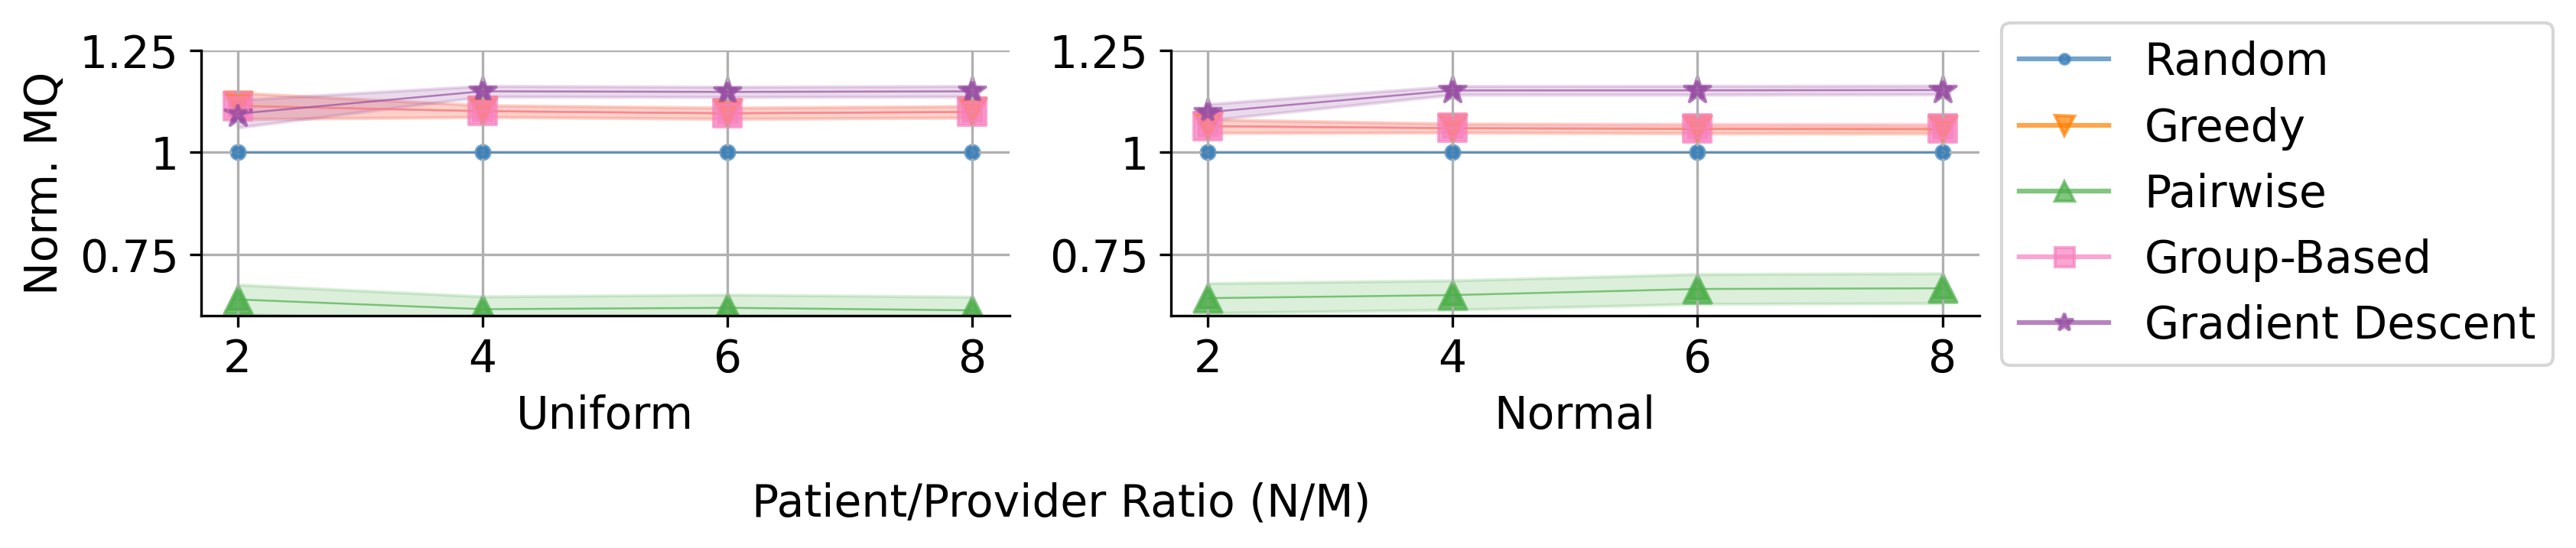

In [16]:
plot_dimensions = (1,2)
x_labels = [["Uniform","Normal"]]
sup_x_label = "Patient/Provider Ratio (N/M)"
y_labels = [["Norm. MQ",""]]
overall_format = {'figsize':(10,1.5),
    'style_size': style_size,
    'x_ticks': [[[x_values,x_values],[x_values,x_values]]],
    'y_ticks': [[[[0.75,1,1.25],[0.75,1,1.25]],[[0.75,1,1.25],[0.75,1,1.25]]]],
    'y_lim': [[[0.6,1.25],[0.6,1.25]]],
    'has_grid': True, 
}

fig,ax = create_axes(plot_dimensions,overall_format,x_labels=x_labels,y_labels=y_labels,sup_x_label=sup_x_label,sup_x_label_loc=-0.5)

line_format = {'color_palette': 'six_color', 'size': 75}
plot_line(ax[0][0],[x_values for i in range(len(ratio_y_values))],ratio_y_values,ratio_confidences,method_labels,line_format)
plot_scatter(ax[0][0],[x_values for i in range(len(ratio_y_values))],ratio_y_values,[None for i in range(len(method_labels))],line_format)

plot_line(ax[0][1],[x_values for i in range(len(ratio_y_values))],ratio_y_values_normal,ratio_confidences_normal,method_labels,line_format)
plot_scatter(ax[0][1],[x_values for i in range(len(ratio_y_values))],ratio_y_values_normal,[None for i in range(len(method_labels))],line_format)


legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'lower left', 'ncol': 1, 'bbox_to_anchor': (0.9,-0.1), 'show_point': True, 'fontsize': 14}
create_legend(fig,ax,plot_dimensions,legend_format)

fig.savefig("../../results/figures/vary_providers_patients.pdf",dpi=300, bbox_inches='tight')

In [17]:
ratio_y_values_match = [[] for i in range(len(methods))]
ratio_confidences_match = [[] for i in range(len(methods))]
baseline_params = {'num_providers': 25,'max_menu_size': 500, 'utility_function': 'uniform'}
dataset = "providers_patients"
x_values = [2,4,6,8]
for i in range(len(x_values)):
    baseline_params['num_patients'] = x_values[i]*25

    results = get_results_matching_parameters(dataset,"",baseline_params)
    print(len(results))
    
    aggregate_data = aggregate_normalize_data(results,baseline="random")
    for method in range(len(method_labels)):
        ratio_y_values_match[method].append(aggregate_data['{}_matches'.format(methods[method])][0])
        ratio_confidences_match[method].append(aggregate_data['{}_matches'.format(methods[method])][1]/len(results)**.5)

15
15
15
15


In [18]:
ratio_y_values_normal_match = [[] for i in range(len(methods))]
ratio_confidences_normal_match = [[] for i in range(len(methods))]
baseline_params = {'num_providers': 25,'max_menu_size': 500, 'utility_function': 'normal'}
dataset = "providers_patients"
x_values = [2,4,6,8]
for i in range(len(x_values)):
    baseline_params['num_patients'] = x_values[i]*25

    results = get_results_matching_parameters(dataset,"",baseline_params)
    print(len(results))
    aggregate_data = aggregate_normalize_data(results,baseline="random")
    for method in range(len(method_labels)):
        ratio_y_values_normal_match[method].append(aggregate_data['{}_matches'.format(methods[method])][0])
        ratio_confidences_normal_match[method].append(aggregate_data['{}_matches'.format(methods[method])][1]/len(results)**.5)

15
15
15
15


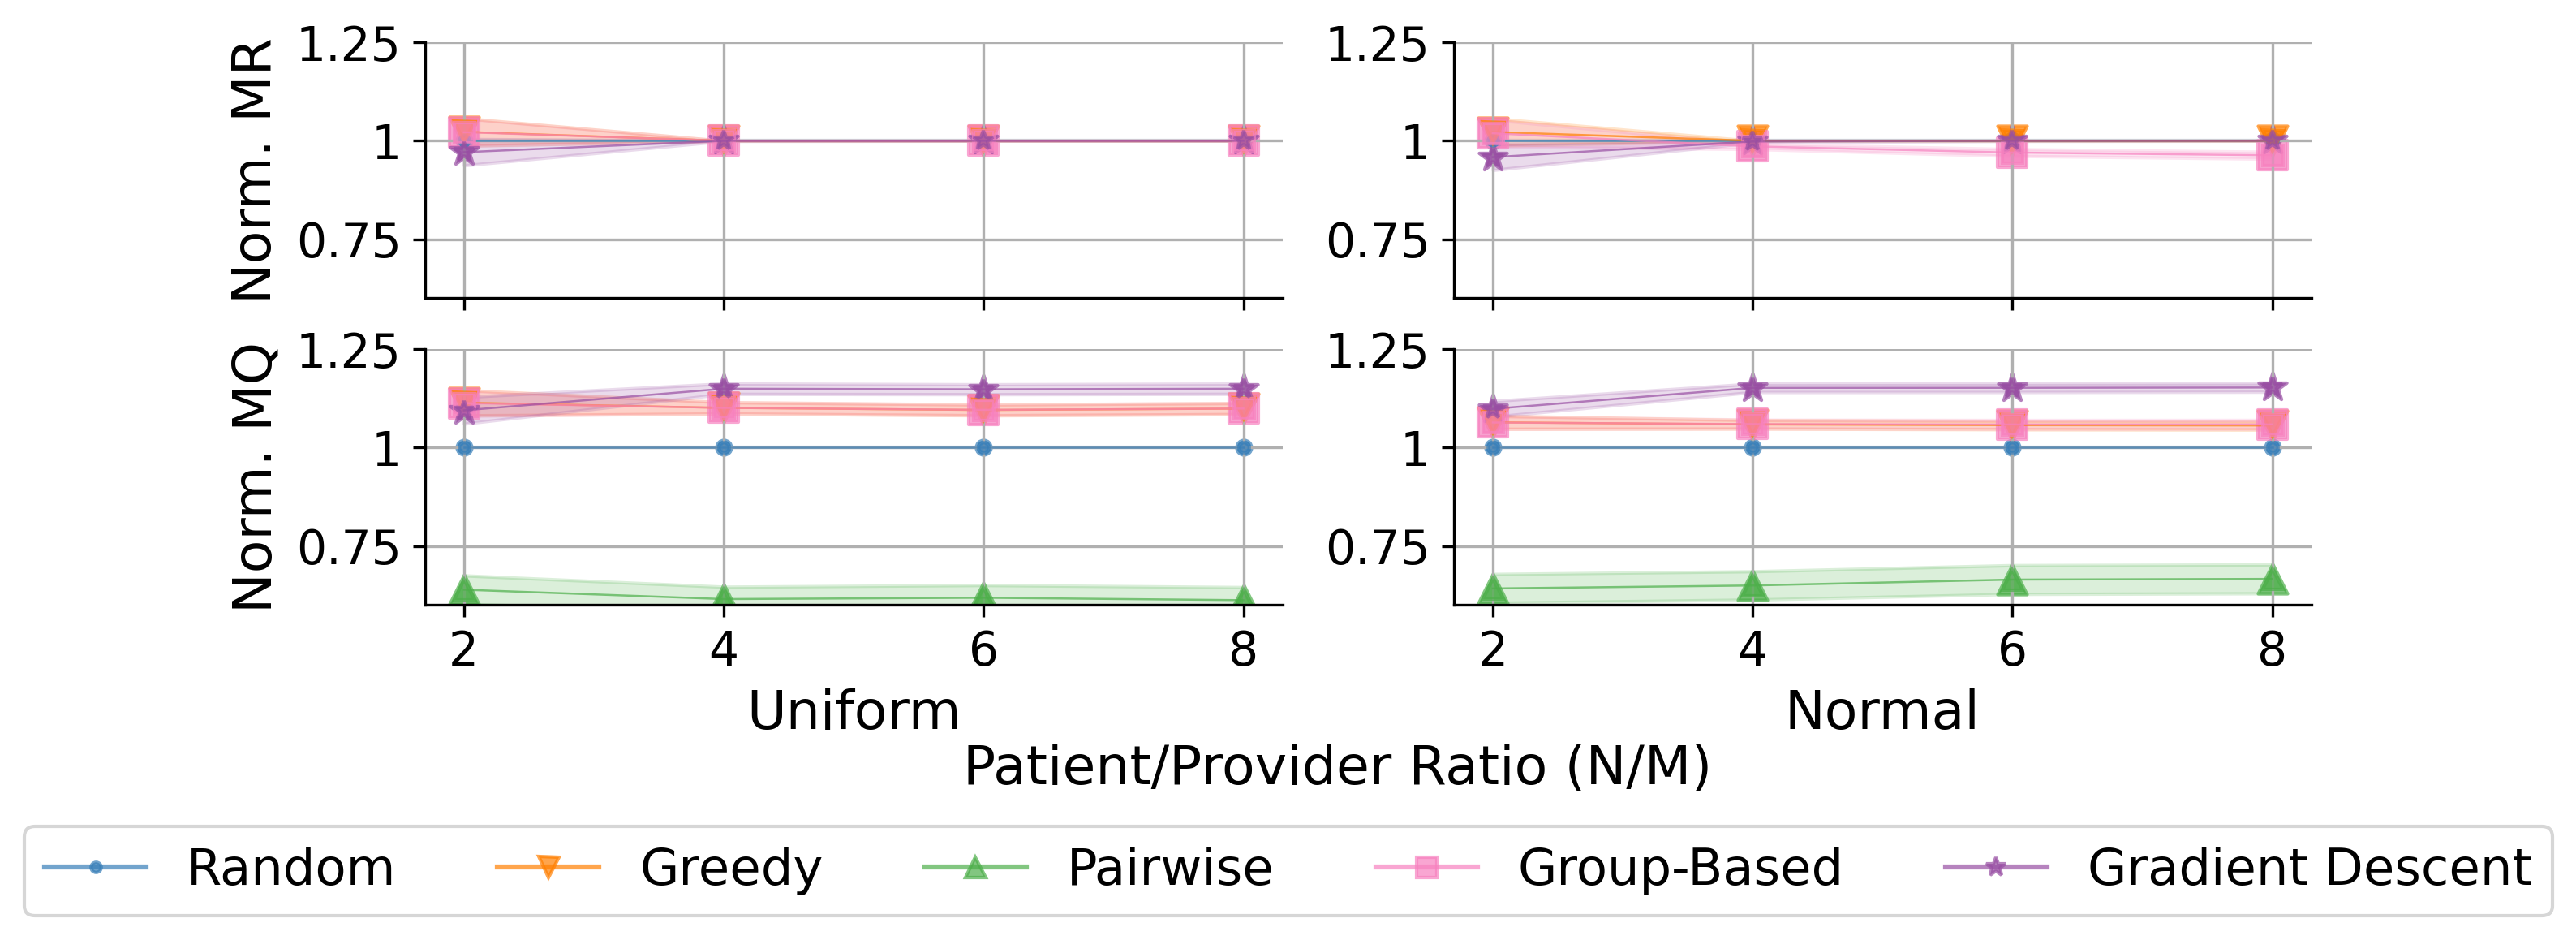

In [28]:
plot_dimensions = (2,2)
x_labels = [["",""],["Uniform","Normal"]]
sup_x_label = "Patient/Provider Ratio (N/M)"
y_labels = [["Norm. MR",""],["Norm. MQ",""]]
overall_format = {'figsize':(10,3),
    'style_size': style_size,
    'x_ticks': [[[x_values,["" for i in range(len(x_values))]] for i in range(2)],[[x_values,x_values] for i in range(2)]],
    'y_ticks': [[[[0.75,1,1.25],[0.75,1,1.25]] for i in range(2)] for i in range(2)],
    'y_lim': [[[0.6,1.25] for i in range(2)] for i in range(2)],
    'has_grid': True, 
    'label_size': 16,
}

fig,ax = create_axes(plot_dimensions,overall_format,x_labels=x_labels,y_labels=y_labels,sup_x_label=sup_x_label,sup_x_label_loc=-0.15)

line_format = {'color_palette': 'six_color', 'size': 75}
plot_line(ax[0][0],[x_values for i in range(len(ratio_y_values))],ratio_y_values_match,ratio_confidences_match,method_labels,line_format)
plot_scatter(ax[0][0],[x_values for i in range(len(ratio_y_values))],ratio_y_values_match,[None for i in range(len(method_labels))],line_format)

plot_line(ax[0][1],[x_values for i in range(len(ratio_y_values))],ratio_y_values_normal_match,ratio_confidences_normal_match,method_labels,line_format)
plot_scatter(ax[0][1],[x_values for i in range(len(ratio_y_values))],ratio_y_values_normal_match,[None for i in range(len(method_labels))],line_format)

plot_line(ax[1][0],[x_values for i in range(len(ratio_y_values))],ratio_y_values,ratio_confidences,method_labels,line_format)
plot_scatter(ax[1][0],[x_values for i in range(len(ratio_y_values))],ratio_y_values,[None for i in range(len(method_labels))],line_format)

plot_line(ax[1][1],[x_values for i in range(len(ratio_y_values))],ratio_y_values_normal,ratio_confidences_normal,method_labels,line_format)
plot_scatter(ax[1][1],[x_values for i in range(len(ratio_y_values))],ratio_y_values_normal,[None for i in range(len(method_labels))],line_format)


legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'lower left', 'ncol': 5, 'bbox_to_anchor': (-0.05,-0.35), 'show_point': True, 'fontsize': 15}
create_legend(fig,ax,plot_dimensions,legend_format)
fig.savefig("../../results/figures/vary_providers_patients_matches.pdf",dpi=300, bbox_inches='tight')

### Other Choice Models

In [ ]:
exit_options = [0.1,0.25,0.5,0.75]
choice_models = ['mnl','threshold']
dataset = "misspecification"

y_value_matrix = [[[0 for i in range(5)] for i in range(4)] for i in range(2)]
y_confidence_matrix = [[[0 for i in range(5)] for i in range(4)] for i in range(2)]

baseline_params = {'num_patients': 100, 'num_providers': 25,'top_choice_prob': 0.5, 'true_top_choice_prob': 0.5, 'fairness_weight': 0}
for i in range(len(y_value_matrix)):
    for j in range(len(y_value_matrix[i])):
        baseline_params['choice_model'] = choice_models[i]
        baseline_params['exit_option'] = exit_options[j]

        results = get_results_matching_parameters(dataset,"",baseline_params)
        aggregate_data = aggregate_normalize_data(results,baseline="random")

        y_value_matrix[i][j] = [aggregate_data['{}_utilities'.format(method)][0] for method in methods]
        y_confidence_matrix[i][j] = [aggregate_data['{}_utilities'.format(method)][1]/((len(results))**.5) for method in methods]

In [ ]:
1.3715564220813468/1.2403520991105634

In [ ]:
y_value_matrix[1]

In [ ]:
np.min(y_value_matrix[0][0][2:])/y_value_matrix[0][0][1]

In [ ]:
y_value_matrix[0][-1][3]/y_value_matrix[0][-1][1]

In [ ]:
np.min(y_value_matrix[0][-1][2:])/y_value_matrix[0][-1][1]

In [ ]:
plot_dimensions = (2,4)
x_labels = [["","","",""],["0.1","0.25","0.5","0.75","0.9"]]
y_labels = [["MNL","","",""],["Threshold","","","",""]]
sup_y_label = "Norm. MQ"
sup_x_label = "Exit Option ($\\gamma$) or Threshold ($\\alpha$)"

overall_format = {'figsize':(10, 2),
    'style_size': style_size,
    'x_ticks': [[[[],[]] for i in range(5)] for i in range(2)],
    'y_lim': [[[0.5,1.5] for i in range(5)] for j in range(2)], 
    'y_ticks': [[[[],[]] if i != 0 else [[0.75,1,1.25],[0.75,1,1.25]] for i in range(5)] for i in range(2)],

}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels,sup_y_label=sup_y_label,sup_x_label=sup_x_label,sup_x_label_loc=-0.15)

bar_format = {'style_size': style_size,
    'color_palette': 'six_color'}

for i in range(2):
    for j in range(4):
        x_groups = [0,1,2,3,4]
        y_values = y_value_matrix[i][j]
        y_errors = y_confidence_matrix[i][j]
        labels = method_labels
        plot_bar(ax[i][j],x_groups,y_values,y_errors,labels,bar_format)

legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'upper right', 'ncol': 5, 'bbox_to_anchor': (0.9,-0.15)}
create_legend(fig,ax,plot_dimensions,legend_format)
fig.savefig("../../results/figures/other_choice_models.pdf",dpi=300, bbox_inches='tight')

In [ ]:
choice_prob = [0.1,0.25,0.5,0.75,0.9]
true_choice_prob = [0.1,0.25,0.5,0.75,0.9][::-1]
dataset = "misspecification"

y_value_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(5)]
y_confidence_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(5)]

baseline_params = {'num_patients': 100, 'num_providers': 25,'top_choice_prob': 0.5, 'true_top_choice_prob': 0.5, 'fairness_weight': 0, 'choice_model': 'uniform_choice'}
for i in range(len(y_value_matrix)):
    for j in range(len(y_value_matrix[i])):
        baseline_params['top_choice_prob'] = choice_prob[j]
        baseline_params['true_top_choice_prob'] = true_choice_prob[i]

        results = get_results_matching_parameters(dataset,"",baseline_params)
        aggregate_data = aggregate_normalize_data(results,baseline="random")

        y_value_matrix[i][j] = [aggregate_data['{}_utilities'.format(method)][0] for method in methods]
        y_confidence_matrix[i][j] = [aggregate_data['{}_utilities'.format(method)][1]/((len(results))**.5) for method in methods]

In [ ]:
plot_dimensions = (5,5)
x_labels = [["","","","",""],["","","","",""],["","","","",""],["","","","",""],["$\hat{p}$=0.1","$\hat{p}$=0.25","$\hat{p}$=0.5","$\hat{p}$=0.75","$\hat{p}$=0.9"]]
y_labels = [["p=0.9","","","",""],["p=0.75","","","",""],["p=0.5","","","",""],["p=0.25","","","",""],["p=0.1","","","",""]]
sup_y_label = "Norm. MQ"
sup_x_label = ""

y_lim = [[0.75,1.75],[0.75,1.4],[0.75,1.5],[0.75,1.5],[0.75,1.5]]

overall_format = {'figsize':(10, 6),
    'style_size': style_size,
    'x_ticks': [[[[],[]] for i in range(5)] for i in range(5)],
    'y_lim': [[y_lim[j] for i in range(5)] for j in range(5)], 
    'y_ticks': [[[[],[]] if i != 0 else [[0.75,1,1.25,1.5],[0.75,1,1.25,1.5]] for i in range(5)] for i in range(5)],

}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels,sup_y_label=sup_y_label,sup_x_label=sup_x_label,sup_x_label_loc=-0.05)

bar_format = {'style_size': style_size,
    'color_palette': 'six_color'}

for i in range(5):
    for j in range(5):
        x_groups = [0,1,2,3,4]
        y_values = y_value_matrix[i][j]
        y_errors = y_confidence_matrix[i][j]
        labels = method_labels
        plot_bar(ax[i][j],x_groups,y_values,y_errors,labels,bar_format)

legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'upper right', 'ncol': 5, 'bbox_to_anchor': (0.92,0.05)}
create_legend(fig,ax,plot_dimensions,legend_format)
fig.savefig("../../results/figures/misspecification.pdf",dpi=300, bbox_inches='tight')

## Semi-Synthetic

In [ ]:
dataset = "semi_synthetic"

y_value_matrix = [0 for i in range(5)]
y_confidence_matrix = [0 for i in range(5)] 

baseline_params = {'num_patients': 1225, 'num_providers': 700, 'max_menu_size': 2000, 'batch_size': 1,'utility_function': 'semi_synthetic_comorbidity', 'fairness_weight': 0}
results = get_results_matching_parameters(dataset,"",baseline_params)
results = [i for i in results if i['parameters']['seed']]
print(len(results))
aggregate_data = aggregate_normalize_data(results,baseline="random")
y_value_matrix = [aggregate_data['{}_utilities'.format(method)][0] for method in methods]
y_confidence_matrix = [aggregate_data['{}_utilities'.format(method)][1]/((len(results))**.5) for method in methods]

In [ ]:
y_value_matrix[-1]/y_value_matrix[1]

In [ ]:
y_value_matrix[-1]/y_value_matrix[1]

In [ ]:
import pandas as pd 
population_csv = pd.read_csv(open("../../data/connecticut_zipcode.csv"))
population_dict = {}
for i in range(len(population_csv)):
    zipcode = str(population_csv.iloc[i,0])
    zipcode = "0"*(5-len(zipcode))+zipcode
    population = int(population_csv.iloc[i,1].replace(",",""))
    population_dict[zipcode] = population

In [ ]:
patients_by_zipcode = {}
providers_by_zipcode = {}

for seed in range(43,58):
    patient_data = json.load(open("../../data/patient_data_{}_1225_700_comorbidity.json".format(seed)))
    provider_data = json.load(open("../../data/provider_data_{}_1225_700_comorbidity.json".format(seed)))

    for p in patient_data:
        other_zip = p['location']
        if other_zip not in patients_by_zipcode:
            patients_by_zipcode[other_zip] = 0
        patients_by_zipcode[other_zip] += 1
    
    for p in provider_data:
        other_zip = str(p['ZIP Code'])
        other_zip = (('0'*(9-len(other_zip)) + other_zip)[:5])
        if other_zip not in providers_by_zipcode:
            providers_by_zipcode[other_zip] = 0
        providers_by_zipcode[other_zip] += 1
for i in patients_by_zipcode:
    patients_by_zipcode[i] /= 15
for i in providers_by_zipcode:
    providers_by_zipcode[i] /= 15


In [ ]:
dataset="semi_synthetic"
baseline_params = {'utility_function': 'semi_synthetic_comorbidity', 'num_patients': 1225, 'batch_size': 1, 'max_menu_size': 2000, 'fairness_weight': 0.0}
matches_by_zipcode = {}
match_quality_by_zipcode = {}
for seed in range(43,58):
    baseline_params['seed'] = seed
    results = get_results_matching_parameters(dataset,"",baseline_params)
    match_rates_per = np.array(results[0]['gradient_descent_fast_matches_per'])
    match_times = np.sum(match_rates_per[0],axis=1)
    patient_data = json.load(open("../../data/patient_data_{}_1225_700_comorbidity.json".format(seed)))
    theta_data = json.load(open("../../data/patient_data_{}_1225_700_comorbidity.json".format(seed)))

    for i in range(len(match_times)):
        zip_val = patient_data[i]['location']
        if zip_val not in matches_by_zipcode:
            matches_by_zipcode[zip_val] = []
        matches_by_zipcode[zip_val].append(match_times[i])

    theta_data = np.array(json.load(open("../../data/{}_1225_700_comorbidity.json".format(seed)))[0])
    theta_data[(theta_data<0.75) & (theta_data>=0.5)] = theta_data[(theta_data<0.75) & (theta_data>=0.5)]+0.25
    theta_data[theta_data>=0.75] = 2*(theta_data[theta_data>=0.75]-0.75)+0.5
    theta_data[theta_data>0] = 10.1/theta_data[theta_data>0]    
    avg_match_quality = np.sum(theta_data*match_rates_per[0],axis=1)
    avg_match_quality[match_times>0] /= match_times[match_times>0]
    for i in range(len(match_times)):
        zip_val = patient_data[i]['location']
        if zip_val not in match_quality_by_zipcode:
            match_quality_by_zipcode[zip_val] = []
        match_quality_by_zipcode[zip_val].append(avg_match_quality[i])

for i in matches_by_zipcode:
    matches_by_zipcode[i] = np.mean(matches_by_zipcode[i])
    match_quality_by_zipcode[i] = np.mean(match_quality_by_zipcode[i])

In [ ]:
dataset="semi_synthetic"
baseline_params = {'utility_function': 'semi_synthetic_comorbidity', 'num_patients': 1225, 'batch_size': 1, 'max_menu_size': 2000, 'fairness_weight': 0.0}
matches_by_zipcode_greedy = {}
match_quality_by_zipcode_greedy = {}
for seed in range(43,58):
    baseline_params['seed'] = seed
    results = get_results_matching_parameters(dataset,"",baseline_params)
    match_rates_per = np.array(results[0]['greedy_matches_per'])
    match_times = np.sum(match_rates_per[0],axis=1)
    patient_data = json.load(open("../../data/patient_data_{}_1225_700_comorbidity.json".format(seed)))
    theta_data = json.load(open("../../data/patient_data_{}_1225_700_comorbidity.json".format(seed)))

    for i in range(len(match_times)):
        zip_val = patient_data[i]['location']
        if zip_val not in matches_by_zipcode_greedy:
            matches_by_zipcode_greedy[zip_val] = []
        matches_by_zipcode_greedy[zip_val].append(match_times[i])

    theta_data = np.array(json.load(open("../../data/{}_1225_700_comorbidity.json".format(seed)))[0])
    theta_data[(theta_data<0.75) & (theta_data>=0.5)] = theta_data[(theta_data<0.75) & (theta_data>=0.5)]+0.25
    theta_data[theta_data>=0.75] = 2*(theta_data[theta_data>=0.75]-0.75)+0.5
    theta_data[theta_data>0] = 10.1/theta_data[theta_data>0]    
    avg_match_quality = np.sum(theta_data*match_rates_per[0],axis=1)
    avg_match_quality[match_times>0] /= match_times[match_times>0]
    for i in range(len(match_times)):
        zip_val = patient_data[i]['location']
        if zip_val not in match_quality_by_zipcode_greedy:
            match_quality_by_zipcode_greedy[zip_val] = []
        match_quality_by_zipcode_greedy[zip_val].append(avg_match_quality[i])

for i in matches_by_zipcode:
    matches_by_zipcode_greedy[i] = np.mean(matches_by_zipcode_greedy[i])
    match_quality_by_zipcode_greedy[i] = np.mean(match_quality_by_zipcode_greedy[i])

In [ ]:
def safe_divide(key,patients,providers):
    if key not in providers:
        return 10000
    if key not in patients:
        return 0
    return patients[key]/providers[key]

In [ ]:
population = np.array(list(ct_zipcodes['population']))
match_rate = np.array(list(ct_zipcodes['match_rate']))
population = population[match_rate > -1]
match_rate = match_rate[match_rate>-1]
coefficients = np.polyfit(population, match_rate, 1)  # Fit a 2nd-degree polynomial
poly = np.poly1d(coefficients)  # Create a polynomial function

# Generate points for the fitted polynomial curve
x_fit = np.linspace(min(population), max(population), 1000)  # Create smooth x values
y_fit = poly(x_fit)  # Get corresponding y values for the fitted curve


In [ ]:
def get_dist(theta_val):
    if theta_val < 0.5:
        return 0
    elif theta_val <= 0.75:
        return 10.1/(2*(theta_val-0.5) + 0.5)
    else:
        return 10.1/(2*(theta_val-0.75)+0.5)

In [ ]:
theta_data = np.array(json.load(open("../../data/{}_1225_700_comorbidity.json".format(seed)))[0])

In [ ]:
np.sum(theta_data*match_rates_per[0])/1225

In [ ]:
dataset="semi_synthetic"
baseline_params = {'utility_function': 'semi_synthetic_comorbidity', 'num_patients': 1225, 'batch_size': 1, 'max_menu_size': 2000, 'fairness_weight': 0.0}
matches_by_comorbidity = {0: [], 1: []} 
distance_by_comorbidity = {0: [], 1: []}
qual_by_comorbidity = {0: [], 1: []}
percent_providers_matched_specialist = []
s = []
for seed in range(43,58):
    baseline_params['seed'] = seed
    results = get_results_matching_parameters(dataset,"",baseline_params)
    print(len(results))

    match_rates_per = np.array(results[0]['gradient_descent_fast_matches_per'])
    match_times = np.sum(match_rates_per[0],axis=1)
    patient_data = json.load(open("../../data/patient_data_{}_1225_700_comorbidity.json".format(seed)))
    theta_data = json.load(open("../../data/patient_data_{}_1225_700_comorbidity.json".format(seed)))

    comorbidity_by_patient = []
    temp_matches_by_comorbidity = {0: [], 1: []}
    for i in range(len(match_times)):
        has_comorbidity = 1 in [patient_data[i][c] for c in ['cardio','gastro','neuro','substance','onco']]
        comorbidity_by_patient.append(int(has_comorbidity))
        temp_matches_by_comorbidity[int(has_comorbidity)].append(match_times[i])
    s.append(np.mean(comorbidity_by_patient))
    for i in range(2):
        matches_by_comorbidity[i].append(np.mean(temp_matches_by_comorbidity[i]))

    theta_data = np.array(json.load(open("../../data/{}_1225_700_comorbidity.json".format(seed)))[0])

    get_dist_vectorized = np.vectorize(get_dist)
    distance_data = get_dist_vectorized(theta_data)


    avg_dist_by_user = np.sum(distance_data*match_rates_per[0],axis=1)
    avg_dist_by_user[match_times>0]/= match_times[match_times>0]
    temp_distance_by_comorbidity = {0: [], 1: []}
    for i in range(len(match_times)):
        if avg_dist_by_user[i]>0:
            temp_distance_by_comorbidity[comorbidity_by_patient[i]].append(avg_dist_by_user[i])
    for i in range(2):
        distance_by_comorbidity[i].append(np.mean(temp_distance_by_comorbidity[i]))

    avg_qual_by_user = np.sum(theta_data*match_rates_per[0],axis=1)
    avg_qual_by_user[match_times>0]/= match_times[match_times>0]
    temp_qual_by_comorbidity = {0: [], 1: []}
    for i in range(len(match_times)):
        if avg_dist_by_user[i]>0:
            temp_qual_by_comorbidity[comorbidity_by_patient[i]].append(avg_qual_by_user[i])
    for i in range(2):
        qual_by_comorbidity[i].append(np.mean(temp_qual_by_comorbidity[i]))

    specialty_grouping = {
        'cardio': ['CARDIOVASCULAR DISEASE (CARDIOLOGY)','ADVANCED HEART FAILURE AND TRANSPLANT CARDIOLOGY','INTERVENTIONAL CARDIOLOGY','CARDIAC ELECTROPHYSIOLOGY','PERIPHERAL VASCULAR DISEASE','CRITICAL CARE (INTENSIVISTS)'], 
        'gastro': ['NEPHROLOGY','ENDOCRINOLOGY'],
        'neuro': ['CRITICAL CARE (INTENSIVISTS)','GERIATRIC MEDICINE','SLEEP MEDICINE'],
        'substance': ['ADDICTION MEDICINE'], 
        'onco': ['CRITICAL CARE (INTENSIVISTS)','HEMATOLOGY','MEDICAL ONCOLOGY'],
    }
    provider_data = json.load(open("../../data/provider_data_{}_1225_700_comorbidity.json".format(seed)))

    providers_with_speciality = [False for i in range(700)]
    for i in range(700):
        for spec in specialty_grouping:
            providers_with_speciality[i]  = providers_with_speciality[i] or any([s in provider_data[i]['sec_spec_all'] for s in specialty_grouping[spec]])
    
    percent_providers_matched_specialist.append(np.sum(theta_data[theta_data>0.75]*match_rates_per[0][theta_data>0.75])/np.sum(providers_with_speciality))


In [ ]:
np.mean(s)

In [ ]:
np.mean(percent_providers_matched_specialist)

In [ ]:
np.mean(temp_matches_by_comorbidity[0]), np.mean(temp_matches_by_comorbidity[1])

In [ ]:
stats.ttest_ind(qual_by_comorbidity[0], qual_by_comorbidity[1])

In [ ]:
np.mean(distance_by_comorbidity[1])/np.mean(distance_by_comorbidity[0])

In [ ]:
np.mean(qual_by_comorbidity[1])/np.mean(qual_by_comorbidity[0])

In [ ]:
plot_dimensions = (1,1)
x_labels = [["","Match Quality"],["Zipcode Population","Match Rate"]]
y_labels =  [["Match Quality",""],["Match Rate",""]]
x_ticks = [[[[],[]],None],[[[0,20000,40000,60000],[0,"2K","4K","6K"]],None]]
sup_y_label = ""
overall_format = {'figsize':(10,4),
    'style_size': style_size,
    'has_grid': False, 
    'x_ticks': x_ticks,
    'label_size': 20,
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels)


bar_format = {'style_size': style_size,
    'color_palette': 'six_color'}

x_groups = [0,1,2,3,4]
y_values = y_value_matrix
y_errors = y_confidence_matrix
labels = method_labels
plot_bar(ax[0][0],x_groups,y_values,y_errors,labels,bar_format)

plt.tight_layout()

legend_format = {'style_size': style_size,'type': 'is_local', 'loc': 'upper right', 'ncol': 3, 'bbox_to_anchor': [[(1,-0.05),()],[(),()]], 'fontsize': 20}
create_legend(fig,ax,plot_dimensions,legend_format)



In [ ]:
plot_dimensions = (2,2)
x_labels = [["","Match Quality"],["Zipcode Population","Match Rate"]]
y_labels =  [["Norm. MQ",""],["Match Rate",""]]
x_ticks = [[[[],[]],None],[[[0,20000,40000,60000],[0,"2K","4K","6K"]],None]]
sup_y_label = ""
overall_format = {'figsize':(10,4),
    'style_size': style_size,
    'has_grid': False, 
    'x_ticks': x_ticks,
    'label_size': 14,
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels)


bar_format = {'style_size': style_size,
    'color_palette': 'six_color'}

x_groups = [0,1,2,3,4]
y_values = y_value_matrix
y_errors = y_confidence_matrix
labels = method_labels
plot_bar(ax[0][0],x_groups,y_values,y_errors,labels,bar_format)


whisker_format = {'color_palette': '#a2cffe', 'style_size': style_size}
plot_box_whisker(ax[0][1],[qual_by_comorbidity[0],qual_by_comorbidity[1]][::-1],["No Com.","Com."][::-1],whisker_format)

scatter_format = {'color_palette': 'two_color_blue_red_light', 'size': 25, 'fontsize': 14}
y_positions = [np.random.normal(i + 1, 0.05, size=len(qual_by_comorbidity[0])) for i in range(2)]
labels = []
plot_scatter(ax[0][1],[qual_by_comorbidity[0],qual_by_comorbidity[1]][::-1],y_positions,labels,scatter_format)


line_format = {'color_palette': '#FF0000DD','no_marker': True, 'linestyle': '--','linewidth': 2, 'size': 25}
plot_line(ax[1][0],[x_fit],[y_fit],[[0 for i in range(len(y_fit))]],[""],line_format)
line_format['color_palette'] = '#FF000022'
plot_scatter(ax[1][0],[population],[match_rate],[],line_format)


cmap = plt.cm.coolwarm
cmap.set_under("grey")  # Values below the range (e.g., -1) will be grey
cmap.set_over("grey")   # Optionally, shade values above the range if needed

# Normalize the color range between 0 and 1
norm = mcolors.Normalize(vmin=0.15, vmax=0.85, clip=False)

colorbar = ct_zipcodes.plot(
    column="match_rate",
    cmap=cmap.reversed(),
    norm=norm,
    legend=True,
    legend_kwds={
        'label': "",
        'orientation': "horizontal",
        'shrink': 1,
        'pad': 0,
    },
    ax=ax[1][1]
)
cbar = ax[1][1].get_figure().axes[-1]  # Access the colorbar axis
cbar.tick_params(labelsize=14)
cbar.set_xticks([0.2, 0.4, 0.6, 0.8])
cbar.set_xlabel("Match Rate", fontsize=14)  # Increase font size for the label




ct_outline = ct_zipcodes.dissolve()
ct_outline.boundary.plot(ax=ax[1][1], color="black", linewidth=1)

# Enhance the plot
ax[1][1].axis("off")
hartford_coords = (41.7637, -72.6851)  # Hartford, CT (latitude, longitude)
newhaven_coords = (41.3083, -72.9279)  # New Haven, CT (latitude, longitude)

# Plot dots for Hartford and New Haven
ax[1][1].scatter(hartford_coords[1], hartford_coords[0], color="black", s=25, zorder=5)  # Hartford
ax[1][1].scatter(newhaven_coords[1], newhaven_coords[0], color="black", s=25, zorder=5)  # New Haven

ax[1][1].text(hartford_coords[1] + 0.07, hartford_coords[0] + 0.03, "Hartford", color="black", fontsize=12, zorder=6)
ax[1][1].text(newhaven_coords[1] + 0.07, newhaven_coords[0] + 0.03, "New Haven", color="black", fontsize=12, zorder=6)


# Show the plot
plt.tight_layout()

legend_format = {'style_size': style_size,'type': 'is_local', 'loc': 'upper right', 'ncol': 3, 'bbox_to_anchor': [[(1.025,-0.035),()],[(),()]], 'fontsize': 10}
create_legend(fig,ax,plot_dimensions,legend_format)
fig.savefig("../../results/figures/semi_synthetic_main.pdf",dpi=300, bbox_inches='tight')

In [ ]:
from matplotlib.transforms import Bbox

x_values = [0.1,5]
x_values.append(x_values[1]+(x_values[1]-x_values[0]))
y_values = [0.2,2,3.8]
fig.savefig("../../results/figures/semi_synthetic_comparison.pdf", bbox_inches=Bbox.from_extents([[x_values[0],y_values[1]],[x_values[1],y_values[2]]]))
fig.savefig("../../results/figures/comorbidity_comparison.pdf", bbox_inches=Bbox.from_extents([[x_values[1],y_values[1]],[x_values[2],y_values[2]]]))
fig.savefig("../../results/figures/scatter_ct.pdf", bbox_inches=Bbox.from_extents([[x_values[0],y_values[0]],[x_values[1],y_values[1]]]))
fig.savefig("../../results/figures/ct_map.pdf", bbox_inches=Bbox.from_extents([[x_values[1],y_values[0]],[x_values[2],y_values[1]]]))


In [ ]:
plot_dimensions = (1,3)
x_labels = [["Patients by ZIP","Providers by ZIP","Proivders/Patient"]]
y_labels =  [["","",""]]
x_ticks = [[[[0,20,40,60],[0,"20","40","60"]] for i in range(3)]]
sup_y_label = ""
overall_format = {'figsize':(10,6),
    'style_size': style_size,
    'has_grid': False, 
    'x_ticks': x_ticks,
    'label_size': 14,
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels)

cmap = plt.cm.coolwarm
cmap.set_under("grey")  # Values below the range (e.g., -1) will be grey
cmap.set_over("grey")   # Optionally, shade values above the range if needed

# Normalize the color range between 0 and 1

for i,column in enumerate(['patients','providers','ratio']):
    if i == 0:
        norm = mcolors.Normalize(vmin=0, vmax=10, clip=False)
    elif i == 1:
        norm = mcolors.Normalize(vmin=0, vmax=10, clip=False)
    elif i == 2:
        norm = mcolors.Normalize(vmin=0, vmax=1, clip=False)
    colorbar = ct_zipcodes.plot(
        column=column,
        cmap=cmap.reversed(),
        norm=norm,
        legend=True,
        legend_kwds={
            'label': "",
            'orientation': "horizontal",
            'shrink': 1,
            'pad': 0,
        },
        ax=ax[0][i]
        
    )
    cbar = ax[0][i].get_figure().axes[-1]  # Access the colorbar axis
    cbar.tick_params(labelsize=14)
    if i == 0:
        cbar.set_xticks([0,5,10])
    elif i == 1:
        cbar.set_xticks([0,5,10])
    elif i == 2:
        cbar.set_xticks([0,0.5,1])
    
    if i == 0:
        cbar.set_xlabel("#Patients", fontsize=14)  # Increase font size for the label
    elif i == 1:
        cbar.set_xlabel("#Providers", fontsize=14)  # Increase font size for the label
    elif i == 2:
        cbar.set_xlabel("Ratio", fontsize=14)  # Increase font size for the label

    ct_outline = ct_zipcodes.dissolve()
    ct_outline.boundary.plot(ax=ax[0][i], color="black", linewidth=1)

    # Enhance the plot
    ax[0][i].axis("off")
    hartford_coords = (41.7637, -72.6851)  # Hartford, CT (latitude, longitude)
    newhaven_coords = (41.3083, -72.9279)  # New Haven, CT (latitude, longitude)

    # Plot dots for Hartford and New Haven
    ax[0][i].scatter(hartford_coords[1], hartford_coords[0], color="black", s=25, zorder=5)  # Hartford
    ax[0][i].scatter(newhaven_coords[1], newhaven_coords[0], color="black", s=25, zorder=5)  # New Haven

    ax[0][i].text(hartford_coords[1] + 0.07, hartford_coords[0] + 0.03, "Hartford", color="black", fontsize=12, zorder=6)
    ax[0][i].text(newhaven_coords[1] + 0.07, newhaven_coords[0] + 0.03, "New Haven", color="black", fontsize=12, zorder=6)


    # Show the plot
    plt.tight_layout()

    legend_format = {'style_size': style_size,'type': 'is_local', 'loc': 'upper right', 'ncol': 3, 'bbox_to_anchor': [[(1.025,-0.035),()],[(),()]], 'fontsize': 10}
    create_legend(fig,ax,plot_dimensions,legend_format)
fig.savefig("../../results/figures/patient_distro.pdf",dpi=300, bbox_inches='tight')

In [ ]:
plot_dimensions = (1,1)
x_labels = [["Patients by ZIP","Providers by ZIP","Proivders/Patient"]]
y_labels =  [["","",""]]
x_ticks = [[[[0,20,40,60],[0,"20","40","60"]] for i in range(3)]]
sup_y_label = ""
overall_format = {'figsize':(4,6),
    'style_size': style_size,
    'has_grid': False, 
    'x_ticks': x_ticks,
    'label_size': 14,
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels)

cmap = plt.cm.coolwarm
cmap.set_under("grey")  # Values below the range (e.g., -1) will be grey
cmap.set_over("grey")   # Optionally, shade values above the range if needed

# Normalize the color range between 0 and 1

for i,column in enumerate(['match_rate_diff']):
    norm = mcolors.Normalize(vmin=-0.5, vmax=0.5, clip=False)
    colorbar = ct_zipcodes.plot(
        column=column,
        cmap=cmap.reversed(),
        norm=norm,
        legend=True,
        legend_kwds={
            'label': "",
            'orientation': "horizontal",
            'shrink': 1,
            'pad': 0,
        },
        ax=ax[0][i]
        
    )
    cbar = ax[0][i].get_figure().axes[-1]  # Access the colorbar axis
    cbar.tick_params(labelsize=14)
    cbar.set_xticks([-0.5,0,0.5])
    
    cbar.set_xlabel("Match Rate Difference", fontsize=14)  # Increase font size for the label

    ct_outline = ct_zipcodes.dissolve()
    ct_outline.boundary.plot(ax=ax[0][i], color="black", linewidth=1)

    # Enhance the plot
    ax[0][i].axis("off")
    hartford_coords = (41.7637, -72.6851)  # Hartford, CT (latitude, longitude)
    newhaven_coords = (41.3083, -72.9279)  # New Haven, CT (latitude, longitude)

    # Plot dots for Hartford and New Haven
    ax[0][i].scatter(hartford_coords[1], hartford_coords[0], color="black", s=25, zorder=5)  # Hartford
    ax[0][i].scatter(newhaven_coords[1], newhaven_coords[0], color="black", s=25, zorder=5)  # New Haven

    ax[0][i].text(hartford_coords[1] + 0.07, hartford_coords[0] + 0.03, "Hartford", color="black", fontsize=12, zorder=6)
    ax[0][i].text(newhaven_coords[1] + 0.07, newhaven_coords[0] + 0.03, "New Haven", color="black", fontsize=12, zorder=6)


    # Show the plot
    plt.tight_layout()

    legend_format = {'style_size': style_size,'type': 'is_local', 'loc': 'upper right', 'ncol': 3, 'bbox_to_anchor': [[(1.025,-0.035),()],[(),()]], 'fontsize': 10}
    create_legend(fig,ax,plot_dimensions,legend_format)
fig.savefig("../../results/figures/match_rate_diff.pdf",dpi=300, bbox_inches='tight')

In [ ]:
batch_y_values = []
batch_y_confidences = []
baseline_params = {'utility_function': 'semi_synthetic_comorbidity', 'max_menu_size': 2000, 'fairness_weight': 0.0}#, 'num_trials': 100, 'order': 'custom'}
dataset = "semi_synthetic"
x_values = [1,2,3,4,5]
for i in range(len(x_values)):
    baseline_params['batch_size'] = x_values[i]

    results = get_results_matching_parameters(dataset,"",baseline_params)
    print(len(results))
    aggregate_data = [np.mean(i['optimal_order_utilities'])/1225 for i in results]

    batch_y_values.append(np.mean(aggregate_data))
    batch_y_confidences.append(np.std(aggregate_data)/len(results)**.5)
batch_y_values = [i/batch_y_values[0] for i in batch_y_values]

In [ ]:
y_values = [x_values[i] * np.log(205/x_values[i]) for i in range(len(x_values))]
y_values = [i/y_values[0] for i in y_values]
y_values 

In [ ]:
plot_dimensions = (1,2)
x_labels = [["Batch Size","Batch Size"]]
y_labels = [["Norm. MQ","Time"]]
overall_format = {'figsize':(4,2),
    'style_size': style_size,
    'x_ticks': [[[x_values,x_values],[x_values,x_values]]],
    'has_grid': True, 
    'constrained_layout': True, 
}

fig,ax = create_axes(plot_dimensions,overall_format,x_labels=x_labels,y_labels=y_labels)

color = '#%02x%02x%02x%02x' % tuple(np.round(np.array(color_schemes['six_color'][-2])*256).astype(int).tolist())
line_format = {'color_palette': color, 'size': 125}
plot_line(ax[0][0],[x_values],[batch_y_values],batch_y_confidences,["Match Quality"],line_format)
plot_scatter(ax[0][0],[x_values],[batch_y_values],[None],line_format)

color = '#%02x%02x%02x%02x' % tuple(np.round(np.array(color_schemes['six_color'][-1])*256).astype(int).tolist())
line_format = {'color_palette': color, 'size': 125}
y_values = [x_values[i] * np.log(205/x_values[i])/np.log(np.log(205/x_values[i])) for i in range(len(x_values))]
y_values = [i/y_values[0] for i in y_values]
y_confidences = [0 for i in range(len(x_values))]
plot_line(ax[0][1],[x_values],[y_values],[y_confidences],["Time"],line_format)
plot_scatter(ax[0][1],[x_values],[y_values],[None],line_format)

fig.savefig("../../results/figures/batch_size.pdf",dpi=300, bbox_inches='tight')

In [ ]:
dataset = "semi_synthetic"

x_value_matrix = [[[0 for i in range(5)] for i in range(3)] for i in range(2)]
y_value_matrix = [[[0 for i in range(5)] for i in range(3)] for i in range(2)]

baseline_params = {'utility_function': 'semi_synthetic_comorbidity', 'num_patients': 1225, 'batch_size': 1, 'fairness_weight': 0.0, 'max_menu_size': 2000}
results = get_results_matching_parameters(dataset,"",baseline_params)
print(len(results))
aggregate_data = aggregate_normalize_data(results)

for i in range(2):
    for j in range(3):
        if j == 0:
            x_value_matrix[i][j] = [aggregate_data['{}_minimums'.format(method)][0] for method in methods]
        elif j == 1:
            x_value_matrix[i][j] = [aggregate_data['{}_variance'.format(method)][0] for method in methods]
        elif j == 2:
            x_value_matrix[i][j] = [aggregate_data['{}_gaps'.format(method)][0] for method in methods]

        if i == 0:
            y_value_matrix[i][j] = [aggregate_data['{}_matches'.format(method)][0] for method in methods]
        elif i == 1:
            y_value_matrix[i][j] = [aggregate_data['{}_utilities'.format(method)][0] for method in methods]


In [ ]:
y_value_matrix = np.array(y_value_matrix)/1225

In [ ]:
plot_dimensions = (2,3)
x_labels = [["","",""],["Min. MQ ($\\rightarrow$)","Var. MQ ($\\leftarrow$)","Range MQ ($\\leftarrow$)"]]
y_labels = [["Avg. MR","",""],["Avg. MQ","",""]]

overall_format = {'figsize':(7, 3),
    'style_size': style_size,
    'y_lim': [[[0.37,0.63] for i in range(3)],[[0.3,0.48] for i in range(3)]],
    'x_lim': [[[0.56,0.69],[0.007,0.0095],[0.32,0.46]] for i in range(2)],
    'y_ticks': [[[[0.4,0.5,0.6],["0.40","0.50","0.60"]] for i in range(3)],[[[0.35,0.4,0.45],["0.35","0.40","0.45"]] for i in range(3)]],
    'x_ticks': [[[[0.6,0.65],[0.6,0.65]],[[0.007,0.008,0.009],[0.007,0.008,0.009]],[[0.35,0.4],[0.35,0.4]]] for i in range(2)],
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels)

scatter_format = {'color_palette': 'six_color', 'size': 200}

for i in range(2):
    for j in range(3):
        x_values = [[k] for k in x_value_matrix[i][j]]
        y_values = y_value_matrix[i][j]
        y_values = [[k] for k in y_values]
        labels = method_labels
        plot_scatter(ax[i][j],x_values,y_values,labels,scatter_format)

plt.tight_layout()
legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'upper right', 'ncol': 5, 'bbox_to_anchor': (1.15,0.1)}
create_legend(fig,ax,plot_dimensions,legend_format)
fig.savefig("../../results/figures/fairness_comparison.pdf",dpi=300, bbox_inches='tight')

In [ ]:
provider_capacity = [1,2,3,4]
dataset = "semi_synthetic"

y_value_matrix = [[0 for i in range(5)] for i in range(2)]
y_confidence_matrix = [[0 for i in range(5)] for i in range(2)]

baseline_params = {'utility_function': 'semi_synthetic_comorbidity', 'num_patients': 1225, 'batch_size': 1, 'max_menu_size': 2000, 'fairness_weight': 0.0}
results = get_results_matching_parameters(dataset,"",baseline_params)
print(len(results))
agg_data = aggregate_data_function(results)

for i,metric in enumerate(["regrets","assortment_sizes"]):
    y_value_matrix[i] = [agg_data['{}_{}'.format(method,metric)][0] for method in methods]
    y_confidence_matrix[i] = [agg_data['{}_{}'.format(method,metric)][1]/((len(results))**.5) for method in methods]

In [ ]:
plot_dimensions = (1,2)
x_labels = [["",""]]
y_labels = [["Regret","Assort. Size","","",""]]

overall_format = {'figsize':(10, 1),
    'style_size': style_size,
    'x_ticks': [[[[],[]] for i in range(2)] for i in range(1)],
    'y_lim': [[[0,0.4],[0,1]]], 
    'y_ticks': [[[[0,0.2,0.4],[0,0.15,0.3]],[[0,0.5,1],[0,0.5,1]]]],
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels)

bar_format = {'style_size': style_size,
    'color_palette': 'six_color'}

for i in range(2):
    x_groups = [0,1,2,3,4]
    y_values = y_value_matrix[i]
    y_errors = y_confidence_matrix[i]
    labels = method_labels
    plot_bar(ax[0][i],x_groups,y_values,y_errors,labels,bar_format)


handles, labels = ax[0][1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=5,bbox_to_anchor=(0.5,-0.125),fontsize=14)
fig.savefig("../../results/figures/regret.pdf",dpi=300, bbox_inches='tight')